In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays
from IPython.core.debugger import set_trace

import utils

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

In [3]:
from tqdm import tqdm_notebook
import collections
import os
import random
import time
import math
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

In [4]:
from models import UnsupervisedRGCN, DistMult
from layers import RelationalGraphConvolution
from training import train_via_ranking, train_via_classification
from evaluation import RankingEvaluation
from datasets import load_dataset, get_relational_adj_dict, get_adj_dict, get_image_features_per_dir

# Datasets and Preprocessing

## Download datasets

In [ ]:
%%bash

# WN18RR.
#cd ../data
#mkdir wn18rr
#cd wn18rr
#wget https://github.com/TimDettmers/ConvE/raw/master/WN18RR.tar.gz
#tar -xvf WN18RR.tar.gz

In [ ]:
%%bash

# FB15K-237.
#cd ../data
#mkdir fb15k-237
#cd fb15k-237
#wget https://download.microsoft.com/download/8/7/0/8700516A-AB3D-4850-B4BB-805C515AECE1/FB15K-237.2.zip
#unzip FB15K-237.2.zip

In [ ]:
%%bash

# YAGO3-10.
#cd ../data
#mkdir yago3-10
#cd yago3-10
#wget https://github.com/TimDettmers/ConvE/raw/master/YAGO3-10.tar.gz
#tar -xvf YAGO3-10.tar.gz

## FB15k-237 / WN18RR / YAGO3-10

In [5]:
#root_dir = '../data/fb15k-237/Release'
root_dir = '../data/wn18rr'
#root_dir = '../data/yago3-10'

num_nodes, num_relations, train_triples, val_triples, test_triples, all_triples, entity_map, relation_map = load_dataset(root_dir)
# TODO: Maybe put those two methods into one with relations=True.
relational_adj_dict = get_relational_adj_dict(train_triples)
#adj_dict = get_adj_dict(train_triples, undirected=True)

## FB15K-237: Numbers (Garcia-Duran et al. 2017)

In [49]:
%%bash

# Download numerical data from Garcia-Duran et al. (2017).
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/nle-ml/mmkb/master/numTriples_FB15k.txt

In [47]:
numerical_features = pd.read_csv('data/fb15k-237/numTriples_FB15k.txt', sep='\t', names=['entity', 'attribute', 'value'])
numerical_features.head()

,entity,attribute,value
0,/m/06rf7,<http://rdf.freebase.com/ns/location.geocode.l...,9.704049e+00
1,/m/06rf7,<http://rdf.freebase.com/ns/location.geocode.l...,5.420868e+01
2,/m/06rf7,<http://rdf.freebase.com/ns/topic_server.popul...,2.837021e+06
3,/m/06rf7,<http://rdf.freebase.com/ns/location.location....,1.576318e+04
4,/m/04258w,<http://rdf.freebase.com/ns/people.person.date...,1.912667e+03


In [46]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with numerical features:', len(numerical_features['entity'].unique()))
print('Intersection (entities in train set with numerical features):', len(np.intersect1d(numerical_features['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with numerical features: 12493
Intersection (entities in train set with numerical features): 12047


## FB15K-237: Numbers and texts (Kristiadi et al. 2018)

In [52]:
%%bash
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/numerical_literals.txt

--2018-03-05 14:44:55--  https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/numerical_literals.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5196154 (5.0M) [text/plain]
Saving to: 'numerical_literals.txt'

     0K .......... .......... .......... .......... ..........  0% 3.99M 1s
    50K .......... .......... .......... .......... ..........  1% 7.02M 1s
   100K .......... .......... .......... .......... ..........  2% 6.95M 1s
   150K .......... .......... .......... .......... ..........  3% 7.05M 1s
   200K .......... .......... .......... .......... ..........  4% 7.89M 1s
   250K .......... .......... .......... .......... ..........  5% 8.27M 1s
   300K .......... .......... .......... .......... ..........  6% 10.7M 1s
   350K .......... ....

In [53]:
numerical_features_kristiadi = pd.read_csv('data/fb15k-237/numerical_literals.txt', sep='\t', names=['entity', 'attribute', 'value'])
numerical_features_kristiadi.head()

,entity,attribute,value
0,/m/0265wl,http://rdf.freebase.com/ns/award.award_categor...,1965
1,/m/0n5c9,http://rdf.freebase.com/ns/location.location.area,1245.78428107
2,/m/0n5c9,http://rdf.freebase.com/ns/location.dated_loca...,1739
3,/m/0n5c9,http://rdf.freebase.com/ns/topic_server.popula...,462263
4,/m/0n5c9,http://rdf.freebase.com/ns/topic_server.popula...,482155


In [54]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with numerical features:', len(numerical_features_kristiadi['entity'].unique()))
print('Intersection (entities in train set with numerical features):', len(np.intersect1d(numerical_features_kristiadi['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with numerical features: 9941
Intersection (entities in train set with numerical features): 9608


In [55]:
%%bash
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/text_literals.txt

--2018-03-05 14:46:55--  https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/text_literals.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12991982 (12M) [text/plain]
Saving to: 'text_literals.txt'

     0K .......... .......... .......... .......... ..........  0% 1.24M 10s
    50K .......... .......... .......... .......... ..........  0% 4.23M 6s
   100K .......... .......... .......... .......... ..........  1% 6.51M 5s
   150K .......... .......... .......... .......... ..........  1% 6.65M 4s
   200K .......... .......... .......... .......... ..........  1% 7.22M 4s
   250K .......... .......... .......... .......... ..........  2% 10.1M 3s
   300K .......... .......... .......... .......... ..........  2% 8.66M 3s
   350K .......... .......... ..

In [56]:
text_features_kristiadi = pd.read_csv('data/fb15k-237/text_literals.txt', sep='\t', names=['entity', 'attribute', 'value'])
text_features_kristiadi.head()

,entity,attribute,value
0,/m/03j9ml,http://rdf.freebase.com/ns/common.topic.descri...,Maggie Roswell is an American film and televis...
1,/m/05cws2,http://rdf.freebase.com/ns/common.topic.descri...,Halesowen Town is an English association footb...
2,/m/0qxzd,http://rdf.freebase.com/ns/common.topic.descri...,"Hayward is a city located in Alameda County, C..."
3,/m/01h18v,http://rdf.freebase.com/ns/common.topic.descri...,About Schmidt is a 2002 American comedy-drama ...
4,/m/0c4y8,http://rdf.freebase.com/ns/common.topic.descri...,"Thomas Lanier ""Tennessee"" Williams III was an ..."


In [59]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with text features:', len(text_features_kristiadi['entity'].unique()))
print('Intersection (entities in train set with text features):', len(np.intersect1d(text_features_kristiadi['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with text features: 14886
Intersection (entities in train set with text features): 13754


## FB15K-237: Images (ImageGraph; Onoro-Rubio et al. 2017)

### Download and compute image features

In [92]:
%%bash

#cd data/fb15k-237
#wget https://www.dropbox.com/s/thct96phmypkaon/image-graph_urls.tar.gz
#tar -xvzf image-graph_urls.tar.gz

--2018-03-12 14:04:52--  https://www.dropbox.com/s/thct96phmypkaon/image-graph_urls.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/ct8mncZqLggve46aNBpGZJ3KEH93mLyB6cpivrWAZImNFpywuiCyOlVYZn5HDjXT/file [following]
--2018-03-12 14:04:52--  https://dl.dropboxusercontent.com/content_link/ct8mncZqLggve46aNBpGZJ3KEH93mLyB6cpivrWAZImNFpywuiCyOlVYZn5HDjXT/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95528096 (91M) [application/octet-stream]
Saving to: 'image-graph_urls.tar.gz'

     0K .......... .......... .......... .......... ..........  0%  633K 2m27s
    50K .......... .......... .......... ...

The bash cell above only downloads the lists with image URLs. Run the script `scripts/download-images.py` to actually download the images.

In [ ]:
# Compute feature vector for each image via VGG19.
feature_tensors_per_mid = get_image_features_per_dir('../data/fb15k-237-onoro-rubio/image-graph_images', show_progress=True)

In [ ]:
len(feature_tensors_per_mid)

In [27]:
feature_tensors_per_mid.keys()[:5]

[u'm.0m0nq', u'm.0gcrg', u'm.01bl7g', u'm.0dwxr', u'm.0g28b1']

In [28]:
feature_tensors_per_mid['m.0gcrg'][0]

array([0.21037243, 0.        , 0.06198356, ..., 0.        , 0.        ,
       0.31102246], dtype=float32)

In [29]:
np.savez_compressed('../data/fb15k-237-onoro-rubio/feature-vectors-vgg19_bn.npz', **feature_tensors_per_mid)

In [30]:
!ls -lh '../data/fb15k-237-onoro-rubio/feature-vectors-vgg19_bn.npz'

-rw-rw-r-- 1 jrieke jrieke 6.8G Apr 17 00:25 ../data/fb15k-237-onoro-rubio/feature-vectors-vgg19_bn.npz


### Compose feature matrix

In [7]:
feature_tensors_per_mid = np.load('../data/fb15k-237-onoro-rubio/feature-vectors-vgg19_bn.npz')

In [8]:
node_features = np.zeros((num_nodes, len(feature_tensors_per_mid['m.0gcrg'][0])))
node_features.shape

(14541, 4096)

In [9]:
for i in range(num_nodes):
    mid = entity_map.from_index(i)[1:].replace('/', '.')
    if mid in feature_tensors_per_mid:
        # TODO: Use image 0 here?
        node_features[i] = feature_tensors_per_mid[mid][0]
    else:
        print('No image for mid:', mid)
        
# TODO: Exclude mids without images from the graph (i.e. from entity_map and triples).

No image for mid: m.013m43
No image for mid: m.014l7h
No image for mid: m.014yzm
No image for mid: m.015c1b
No image for mid: m.015cjr
No image for mid: m.01sh2
No image for mid: m.01svq8
No image for mid: m.01z4y
No image for mid: m.025rxky
No image for mid: m.026f5s
No image for mid: m.026sv5l
No image for mid: m.0283ph
No image for mid: m.029j_
No image for mid: m.02cllz
No image for mid: m.02flpq
No image for mid: m.02jjdr
No image for mid: m.02jxk
No image for mid: m.02kc008
No image for mid: m.02kxbwx
No image for mid: m.02kxbx3
No image for mid: m.02p3cr5
No image for mid: m.02qsfzv
No image for mid: m.02vs3x5
No image for mid: m.03d49
No image for mid: m.03hbzj
No image for mid: m.03hfwhq
No image for mid: m.03p41
No image for mid: m.03tp4
No image for mid: m.03y5g8
No image for mid: m.0488g
No image for mid: m.04_xr8
No image for mid: m.04hhv
No image for mid: m.04vjh
No image for mid: m.04xvh5
No image for mid: m.05byxm
No image for mid: m.05h83
No image for mid: m.05hd32
No 

In [10]:
node_features[0, :100]

array([0.00684658, 0.        , 0.        , 0.        , 0.94227618,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       2.04585981, 0.80015063, 0.        , 0.        , 0.37703696,
       0.90790474, 1.13492382, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.7615056 , 0.68083048, 0.        ,
       0.        , 0.        , 0.        , 0.04108927, 0.        ,
       0.        , 0.        , 0.        , 0.73085588, 0.        ,
       0.99910861, 0.        , 0.        , 0.        , 0.        ,
       0.12150977, 1.27391827, 0.84002841, 1.03071761, 0.03856321,
       0.38938725, 0.35968941, 0.        , 0.09479136, 0.16519678,
       0.        , 1.02492809, 0.63049942, 0.11860285, 0.        ,
       0.        , 0.        , 0.        , 1.15898585, 0.        ,
       0.58641452, 0.35156584, 0.03120092, 0.        , 0.        ,
       1.05061924, 0.        , 0.        , 0.81632972, 1.64456

In [16]:
set1 = set(entity_map._value_to_index.keys())

In [19]:
set2 = set(['/' + s.replace('.', '/') for s in feature_tensors_per_mid.keys()])

In [20]:
len(set1), len(set2), len(set2.intersection(set1))

(14541, 10221, 9967)

In [21]:
len(os.listdir('../data/fb15k-237-onoro-rubio/image-graph_images'))

14855

## YAGO3-10: Images (Pezheskpour et al. 2017)

Download manually from https://github.com/pouyapez/multim-kb-embeddings/tree/master/datasets/YAGO-10%20plus

Unpack into `../data/yago3-10-pezheskpour`

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    """
    Download a large file from Google Drive via a shared link.
    
    Large files cannot be downloaded from Google Drive via wget.
    From: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
    """
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

In [35]:
!mkdir ../data/yago3-10-pezheskpour

In [57]:
!ls ../data/yago3-10-pezheskpour

image.rar


In [58]:
!cat ../data/yago3-10-pezheskpour/image.rar

<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

In [56]:
download_file_from_google_drive('1qHbrTe_jGPJ1a_4KhFE1GCrLxaKAB-Q9', '../data/yago3-10-pezheskpour/image.rar')

In [49]:
!rm ../data/yago3-10-pezheskpour/image.rar

In [9]:
%%bash
ggID='1qHbrTe_jGPJ1a_4KhFE1GCrLxaKAB-Q9'  
ggURL='https://drive.google.com/uc?export=download'  
filename="$(curl -sc --insecure /tmp/gcokie "${ggURL}&id=${ggID}" | grep -o '="uc-name.*</span>' | sed 's/.*">//;s/<.a> .*//')"  
getcode="$(awk '/_warning_/ {print $NF}' /tmp/gcokie)"  
curl -Lb --insecure /tmp/gcokie "${ggURL}&confirm=${getcode}&id=${ggID}" -o "${filename}"  

<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

curl: (3) <url> malformed
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3277    0  3277    0     0  10850      0 --:--:-- --:--:-- --:--:-- 10850


In [10]:
!ls

--insecure  download-images.py	images.rar  playground.ipynb  utils.pyc
README.md   image.rar		logs	    utils.py


In [11]:
!cat image.rar

<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

In [8]:
%%bash
curl -c /tmp/cookies "https://drive.google.com/uc?export=download&id=1qHbrTe_jGPJ1a_4KhFE1GCrLxaKAB-Q9" > /tmp/intermezzo.html
cat /tmp/intermezzo.html
echo $(cat /tmp/intermezzo.html | grep -Po 'uc-download-link" [^>]* href="\K[^"]*' | sed 's/\&amp;/\&/g')
curl -L -b /tmp/cookies "https://drive.google.com$(cat /tmp/intermezzo.html | grep -Po 'uc-download-link" [^>]* href="\K[^"]*' | sed 's/\&amp;/\&/g')" > 'images.rar'


<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3267    0  3267    0     0  14986      0 --:--:-- --:--:-- --:--:-- 14986
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3284    0  3284    0     0  15638      0 --:--:-- --:--:-- --:--:-- 15563


In [2]:
!ls

README.md	    image.rar	logs		  utils.py
download-images.py  images.rar	playground.ipynb  utils.pyc


In [3]:
!cat images.rar

<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

## MovieLens-100k

In [29]:
%%bash
#cd data
#mkdir movielens-100k
#wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
#unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


--2018-03-08 01:22:47--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: 'ml-100k.zip'

     0K .......... .......... .......... .......... ..........  1%  228K 21s
    50K .......... .......... .......... .......... ..........  2%  460K 15s
   100K .......... .......... .......... .......... ..........  3% 5.27M 10s
   150K .......... .......... .......... .......... ..........  4% 7.53M 8s
   200K .......... .......... .......... .......... ..........  5%  494K 8s
   250K .......... .......... .......... .......... ..........  6% 4.55M 7s
   300K .......... .......... .......... .......... ..........  7%  511K 7s
   350K .......... .......... .......... .......... ..........  8% 7.69M 6s
   400K .......... .......... ...

In [13]:
# TODO: Do not use complete dataset here, but one of the official splits.
triples = pd.read_csv('../data/movielens-100k/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
triples.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [14]:
user_map = utils.IndexMap(triples['user_id'])
item_map = utils.IndexMap(triples['item_id'], start_index=len(user_map))

In [15]:
num_nodes = len(user_map) + len(item_map)
num_nodes

2625

In [16]:
feat_data = np.eye(num_nodes)

In [17]:
num_classes = 2
labels = np.zeros(num_nodes)
labels[:len(user_map)] = 1
labels = labels.reshape(-1, 1)
labels

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [18]:
# TODO: Refactor to methods create_adj_dict(subjects, objects) and create_relational_adj_dict(subjects, objects, relations).
adj_dict = collections.defaultdict(set)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    adj_dict[user_index].add(item_index)
    adj_dict[item_index].add(user_index)  # undirected edges

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [19]:
# TODO: Refactor to methods create_adj_dict(subjects, objects) and create_relational_adj_dict(subjects, objects, relations).
directed_adj_dict = collections.defaultdict(set)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    directed_adj_dict[user_index].add(item_index)
    #directed_adj_dict[item_index].add(user_index)  # undirected edges

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [20]:
# For relational model.
rating_map = utils.IndexMap(triples['rating'])
num_relations = len(rating_map)
num_relations

5

In [21]:
relational_adj_dict = collections.defaultdict(dict)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    rating_index = rating_map.to_index(row['rating'])
    
    if item_index in relational_adj_dict[user_index]:
        print('Edge {} -> {} already exists with relation {}'.format(user_index, item_index, 
                                                                     relational_adj_dict[user_index][item_index]))
        print('This edge will be overwritten by the new relation {}'.format(rating_index))
    relational_adj_dict[user_index][item_index] = rating_index
    relational_adj_dict[item_index][user_index] = rating_index

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [22]:
# For link prediction.
from_nodes = triples['user_id'].map(user_map.to_index)
to_nodes = triples['item_id'].map(item_map.to_index)
relations = triples['rating'].map(rating_map.to_index)

triples_arr = np.vstack([from_nodes, to_nodes, relations]).T
len(triples_arr), triples_arr

(100000, array([[ 195, 1184,    2],
        [ 185, 1244,    2],
        [  21, 1319,    0],
        ...,
        [ 275, 2032,    0],
        [  12, 1167,    1],
        [  11, 1145,    2]]))

## MovieLens-100k: Metadata (included with original dataset)

In [86]:
from keras.utils import to_categorical

In [90]:
movies = pd.read_csv('data/movielens-100k/ml-100k/u.item', sep='|', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [91]:
users = pd.read_csv('data/movielens-100k/ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
# TODO: How to encode those features? Movies and users have inherently different features/feature vectors!?

## MovieLens-100k: Images (Pezheskpour et al. 2017)

Download manually from https://github.com/pouyapez/multim-kb-embeddings/tree/master/datasets/Movielens-100k%20plus

Unpack into `../data/movielens-100k-pezheskpour`

In [25]:
!ls ../data

cora	   fb15k-237-garcia-duran  movielens-100k
cora.tgz   fb15k-237-kristiadi	   movielens-100k-pezheskpour
fb15k-237  fb15k-237-onoro-rubio   yago3-10


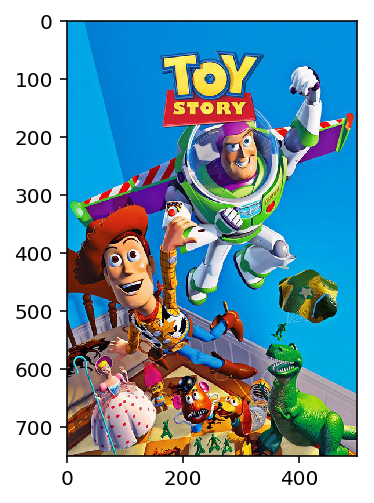

In [79]:
plt.imshow(plt.imread('data/movielens-100k/image/1.jpg'))

## Cora

In [ ]:
from graphsage.model import load_cora

In [ ]:
feat_data, labels, adj_lists = load_cora()
num_nodes, num_feats = feat_data.shape
num_classes = len(np.unique(labels))

num_nodes, num_feats, num_classes

In [ ]:
# Optional: Remove features and use identity matrix instead. 
# Set learning rate to 10 for this.
feat_data = np.eye(num_nodes)
num_feats = num_nodes

num_nodes, num_feats, num_classes

# Supervised Classification (without relations and features)

In [16]:
class SupervisedGCN(nn.Module):

    def __init__(self, num_classes, feat_data, adj_lists):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        
        features = nn.Embedding(num_nodes, num_features)
        features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.graph_conv1 = GraphConvolution(num_features, 128, features, adj_lists, activation=F.relu)
        self.graph_conv2 = GraphConvolution(128, 128, self.graph_conv1, adj_lists, activation=F.relu)
        
        # TODO: Converges faster without bias. See if this holds for real data.
        self.dense = nn.Linear(128, num_classes, bias=False)
        nn.init.xavier_uniform(self.dense.weight)

    def forward(self, nodes):
        node_embeddings = self.graph_conv2(nodes)  # implicitly calls underlying conv layers
        scores = self.dense(node_embeddings)
        return scores

In [17]:
# Run algorithm.
np.random.seed(1)
random.seed(1)

use_cuda = True

net = SupervisedGCN(num_classes, feat_data, adj_dict)
if use_cuda and torch.cuda.is_available():
    print('Moving network to GPU.')
    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

times = []
for batch in range(100):
    #batch_nodes = Variable(torch.LongTensor(train[:256]), requires_grad=False)
    batch_nodes = train[:256]
    random.shuffle(train)
    
    start_time = time.time()
    
    optimizer.zero_grad()
    
    output = net(batch_nodes)
    target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
    if use_cuda and torch.cuda.is_available():
        target = target.cuda()
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 10 == 0:
        val_output = net(val) 
        print("Validation Accuracy:", accuracy_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1)))
        print("Validation F1:", f1_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1), average="micro"))
        print("Average batch time:", np.mean(times))

Moving network to GPU.
0 0.692896485329
Validation Accuracy: 0.634
Validation F1: 0.634
Average batch time: 0.1904129981994629
1 0.667886972427
2 0.612422704697
3 0.529688358307
4 0.42939171195
5 0.319299668074
6 0.250481367111
7 0.250862538815
8 0.194756746292
9 0.183181121945
10 0.152682065964
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06710889122702858
11 0.123559959233
12 0.0772185176611
13 0.0510042309761
14 0.0365696884692
15 0.0187319889665
16 0.0101769454777
17 0.00538808479905
18 0.00236057955772
19 0.000963839702308
20 0.000447682105005
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06511790411812919
21 0.00017000362277
22 8.49878415465e-05
23 3.43294814229e-05
24 1.98967754841e-05
25 1.02631747723e-05
26 4.99188899994e-06
27 2.59838998318e-06
28 1.47707760334e-06
29 2.25566327572e-06
30 1.52364373207e-06
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06462906252953314
31 4.22820448875e-07
32 1.02631747723e-06
33 6.

In [174]:
# Alternative version with epochs and progressbar.
# TODO: Update CUDA support.

from tqdm import tqdm

# Run algorithm.
np.random.seed(1)
random.seed(1)

net = SupervisedGCN(num_classes, feat_data, adj_lists)
#    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

num_epochs = 10
batch_size = 256

for epoch in range(1, num_epochs+1):
    
    
    #tqdm.write('Epoch {}/{}:'.format(epoch, num_epochs-1))

    random.shuffle(train)
    num_batches = int(len(train) / batch_size)
    
    with tqdm(total=num_batches, desc='Epoch {}/{}'.format(epoch, num_epochs), ncols=110) as pbar:

        for batch in range(num_batches):

            #print('\tBatch {}/{}:'.format(batch, num_batches-1), end=' ')

            from_node = batch * batch_size
            to_node = min((batch + 1) * batch_size, len(train))
            batch_nodes = train[from_node:to_node]

            optimizer.zero_grad()

            output = net(batch_nodes)
            target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=loss.data[0])
            #print(loss.data[0])
            
            pbar.update()

        val_output = net(val) 
        val_acc = accuracy_score(labels[val], val_output.data.numpy().argmax(axis=1))
        val_f1 = f1_score(labels[val], val_output.data.numpy().argmax(axis=1), average="micro")
        pbar.set_postfix(loss=loss.data[0], val_acc=val_acc, val_f1=val_f1)


Epoch 10/10: 100%|██████████████████████████| 6/6 [00:01<00:00,  6.64it/s, loss=1.61e-13, val_acc=1, val_f1=1]


# Supervised Classification with relations

In [16]:
class SupervisedRGCN(nn.Module):

    def __init__(self, num_classes, feat_data, adj_lists_per_relation):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        features = nn.Embedding(num_nodes, num_features)
        features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.graph_conv1 = RelationalGraphConvolution(num_features, 128, features, adj_lists_per_relation)
        self.graph_conv2 = RelationalGraphConvolution(128, 128, self.graph_conv1, adj_lists_per_relation)
        
        # TODO: Converges faster without bias. See if this holds for real data.
        self.dense = nn.Linear(128, num_classes, bias=False)
        nn.init.xavier_uniform(self.dense.weight)

    def forward(self, nodes):
        node_embeddings = self.graph_conv2(nodes)  # implicitly calls underlying conv layers
        #print(node_embeddings.sum())
        scores = self.dense(node_embeddings)  # softmax is applied by CrossEntropyLoss
        return scores


In [19]:
# Run algorithm.
np.random.seed(1)
random.seed(1)

use_cuda = True

net = SupervisedRGCN(num_classes, feat_data, adj_lists_per_relation)
if use_cuda and torch.cuda.is_available():
    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])
print('Training on', len(train), 'nodes')

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

times = []
for batch in range(100):
    #batch_nodes = Variable(torch.LongTensor(train[:256]), requires_grad=False)
    
    random.shuffle(train)
    batch_nodes = train[:256]
    
    start_time = time.time()
    
    optimizer.zero_grad()
    
    output = net(batch_nodes)
    target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
    if use_cuda and torch.cuda.is_available():
        target = target.cuda()
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 10 == 0:
        val_output = net(val) 
        print("Validation Accuracy:", accuracy_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1)))
        print("Validation F1:", f1_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1), average="micro"))
        print("Average batch time:", np.mean(times))

Training on 1625 nodes
0 0.690665960312
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.19429492950439453
1 0.56970000267
2 0.422767162323
3 0.333146989346
4 0.244888827205
5 0.187118723989
6 0.116868980229
7 0.0616429522634
8 0.031066134572
9 0.0174713600427
10 0.00768253672868
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.1721870248967951
11 0.00573282269761
12 0.00264684483409
13 0.00133715290576
14 0.00102490792051
15 0.00063599832356
16 0.000389914028347
17 0.000162918586284
18 0.000254969578236
19 0.000120875425637
20 8.7134540081e-06
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.16201589221046084
21 8.99191945791e-06
22 1.94106251001e-05
23 1.6987323761e-06
24 1.47707760334e-06
25 3.20374965668e-07
26 4.7042965889e-05
27 1.33737921715e-05
28 8.17980617285e-06
29 8.38190317154e-08
30 1.30385160446e-07
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.1524044159919985
31 2.64495611191e-07
32 1.63912773132e-0

# Link Prediction

In [6]:
# Set up dataset splits and ranking evaluation. 
#train_triples, val_triples, test_triples = utils.train_val_test_split(all_triples, val_size=5000, test_size=5000, random_state=0)

filtered = False
train_ranker = RankingEvaluation(train_triples[:5000], num_nodes, filter_triples=all_triples if filtered else None, show_progress=True)
val_ranker = RankingEvaluation(val_triples, num_nodes, filter_triples=all_triples if filtered else None, show_progress=True)
#test_ranker = RankingEvaluation(test_triples, num_nodes, filter_triples=all_triples if filtered else None, show_progress=True)

## Single training run

In [7]:
force_cpu = False
history = utils.History()

In [8]:
# Option 1: R-GCN
utils.seed_all(0)
net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200, dist_mult_dropout=0.5, 
                       num_sample_train=10, num_sample_eval=10, activation=F.elu)#,
                       #regularization='basis')#, verbose=True)#,
                       #node_features=node_features)
embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
if torch.cuda.is_available() and not force_cpu:
    net.cuda()
    print('Moved network to GPU')
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
batch_size = 64
#train_forward_kwargs = dict(num_sample=10)
#val_forward_kwargs = dict(num_sample=None)

Initialized with OneHotEmbedding
Moved network to GPU


In [ ]:
%debug

> /home/jrieke/Projects/multimodal-gcn/layers.py(175)__init__()
    173             block_height = out_features / num_blocks
    174             if not block_width.is_integer() or not block_height.is_integer():
--> 175                 raise ValueError('in_features and out_features has to be divisible by num_blocks')
    176 
    177             if verbose: print('Constructing blocks of size', block_width, ' - ', block_height)

ipdb> block_width
1454.1
ipdb> block_height
20.0
ipdb> in_features
14541


In [ ]:
# Option 2: DistMult
# TODO: In original DistMult paper, embeddings are normalized to unit length after each training step. Improves model empricially.
utils.seed_all(0)
net = TransE(200, num_nodes, num_relations, 0.4)
embedding_func, scoring_func = net.get_embeddings, net.decoder  # required for ranking
if torch.cuda.is_available() and not force_cpu:
    net.cuda()
    print('Moved network to GPU')
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
batch_size = 32
train_forward_kwargs = dict()
val_forward_kwargs = dict()

In [9]:
### TODO: Handle the embedding_func/scoring_func here better.
#       Maybe through function train_ranking_func = lambda: train_ranker(embedding_func, scoring_func) above.
#       Or define training functions in here and use most variables from the global namespace.
#       Then: train_via_ranking(net, optimizer, num_epochs, batch_size, margin, history=None)
train_via_ranking(net, train_triples, val_triples, optimizer, num_nodes, train_ranker, val_ranker, 
                  embedding_func, scoring_func, num_epochs=35, batch_size=batch_size, batch_size_val=64, 
                  margin=1, history=history, dry_run=False)

Epoch 1/35


HBox(children=(IntProgress(value=0, max=1357), HTML(value=u'')))


Loss:       0.320337532833
Val Loss:   0.565218760942

Accuracy:       0.883880288485
Val Accuracy:   0.769130608688

Mean Difference:       2.92763803728
Val Mean Difference:   1.92811301847

Median Difference:       2.39015159065
Val Median Difference:   1.27693536133

Running rank evaluation for train in raw setting...
Running rank evaluation for val in raw setting...
Mean Rank:       1176.95015
Val Mean Rank:   9306.0308174

Mean Rec Rank:       0.0750993270668
Val Mean Rec Rank:   0.019436405025

Hits@1:       0.037
Val Hits@1:   0.0074159525379

Hits@3:       0.0706
Val Hits@3:   0.0181278839815

Hits@10:       0.1479
Val Hits@10:   0.037903757416

--------------------------------------------------------------------------------

Epoch 2/35


HBox(children=(IntProgress(value=0, max=1357), HTML(value=u'')))

KeyboardInterrupt: 

In [10]:
a = torch.zeros(5, 5, 5)
b = torch.zeros(5, 5, 5)

In [ ]:
a.addbmm()

In [ ]:
%debug

> /home/jrieke/anaconda2/lib/python2.7/site-packages/torch/nn/modules/sparse.py(103)forward()
    101             input, self.weight,
    102             padding_idx, self.max_norm, self.norm_type,
--> 103             self.scale_grad_by_freq, self.sparse
    104         )
    105 

ipdb> up
> /home/jrieke/anaconda2/lib/python2.7/site-packages/torch/nn/modules/module.py(357)__call__()
    355             result = self._slow_forward(*input, **kwargs)
    356         else:
--> 357             result = self.forward(*input, **kwargs)
    358         for hook in self._forward_hooks.values():
    359             hook_result = hook(self, input, result)

ipdb> up
> /home/jrieke/Projects/multimodal-gcn/models.py(71)forward()
     69         object_embeddings = self.dropout(object_embeddings)
     70 
---> 71         relation_embeddings = self.relation_embedding(relations)#_tensor)
     72         scores = (subject_embeddings * relation_embeddings * object_embeddings).sum(1, keepdim=True)
     73

In [10]:
%lprun -f net.graph_conv1.forward train_via_ranking(net, train_triples, val_triples, optimizer, num_nodes, train_ranker, val_ranker, embedding_func, scoring_func, num_epochs=35, batch_size=batch_size, batch_size_val=16, margin=1, history=history)

Epoch 1/35


HBox(children=(IntProgress(value=0, max=1357), HTML(value=u'')))

*** KeyboardInterrupt exception caught in code being profiled.

In [10]:
# TODO: Maybe refactor training_via_ranking and training_via_classification to class or sth similar.
train_via_classification(net, train_triples, val_triples, optimizer, num_nodes, train_ranker, val_ranker, 
                         embedding_func, scoring_func, num_epochs=25, batch_size=batch_size, batch_size_val=16, 
                         num_negatives=1, history=history, dry_run=False)

Epoch 1/25


HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))


Loss:       0.69315558672
Val Loss:   0.693125456572

Accuracy:       0.46875
Val Accuracy:   0.625

Running rank evaluation for train in raw setting...
Running rank evaluation for val in raw setting...
Mean Rank:       7275.59795
Val Mean Rank:   7271.17812946

Mean Rec Rank:       0.000763613871038
Val Mean Rec Rank:   0.000927470761271

Hits@1:       0.0001
Val Hits@1:   0.000256629597947

Hits@3:       0.0001
Val Hits@3:   0.000399201596806

Hits@10:       0.0011
Val Hits@10:   0.00108354719133

--------------------------------------------------------------------------------

Epoch 2/25


HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))


Loss:       0.693122893572
Val Loss:   0.693136721849

Accuracy:       0.578125
Val Accuracy:   0.5625

Running rank evaluation for train in raw setting...


KeyboardInterrupt: 

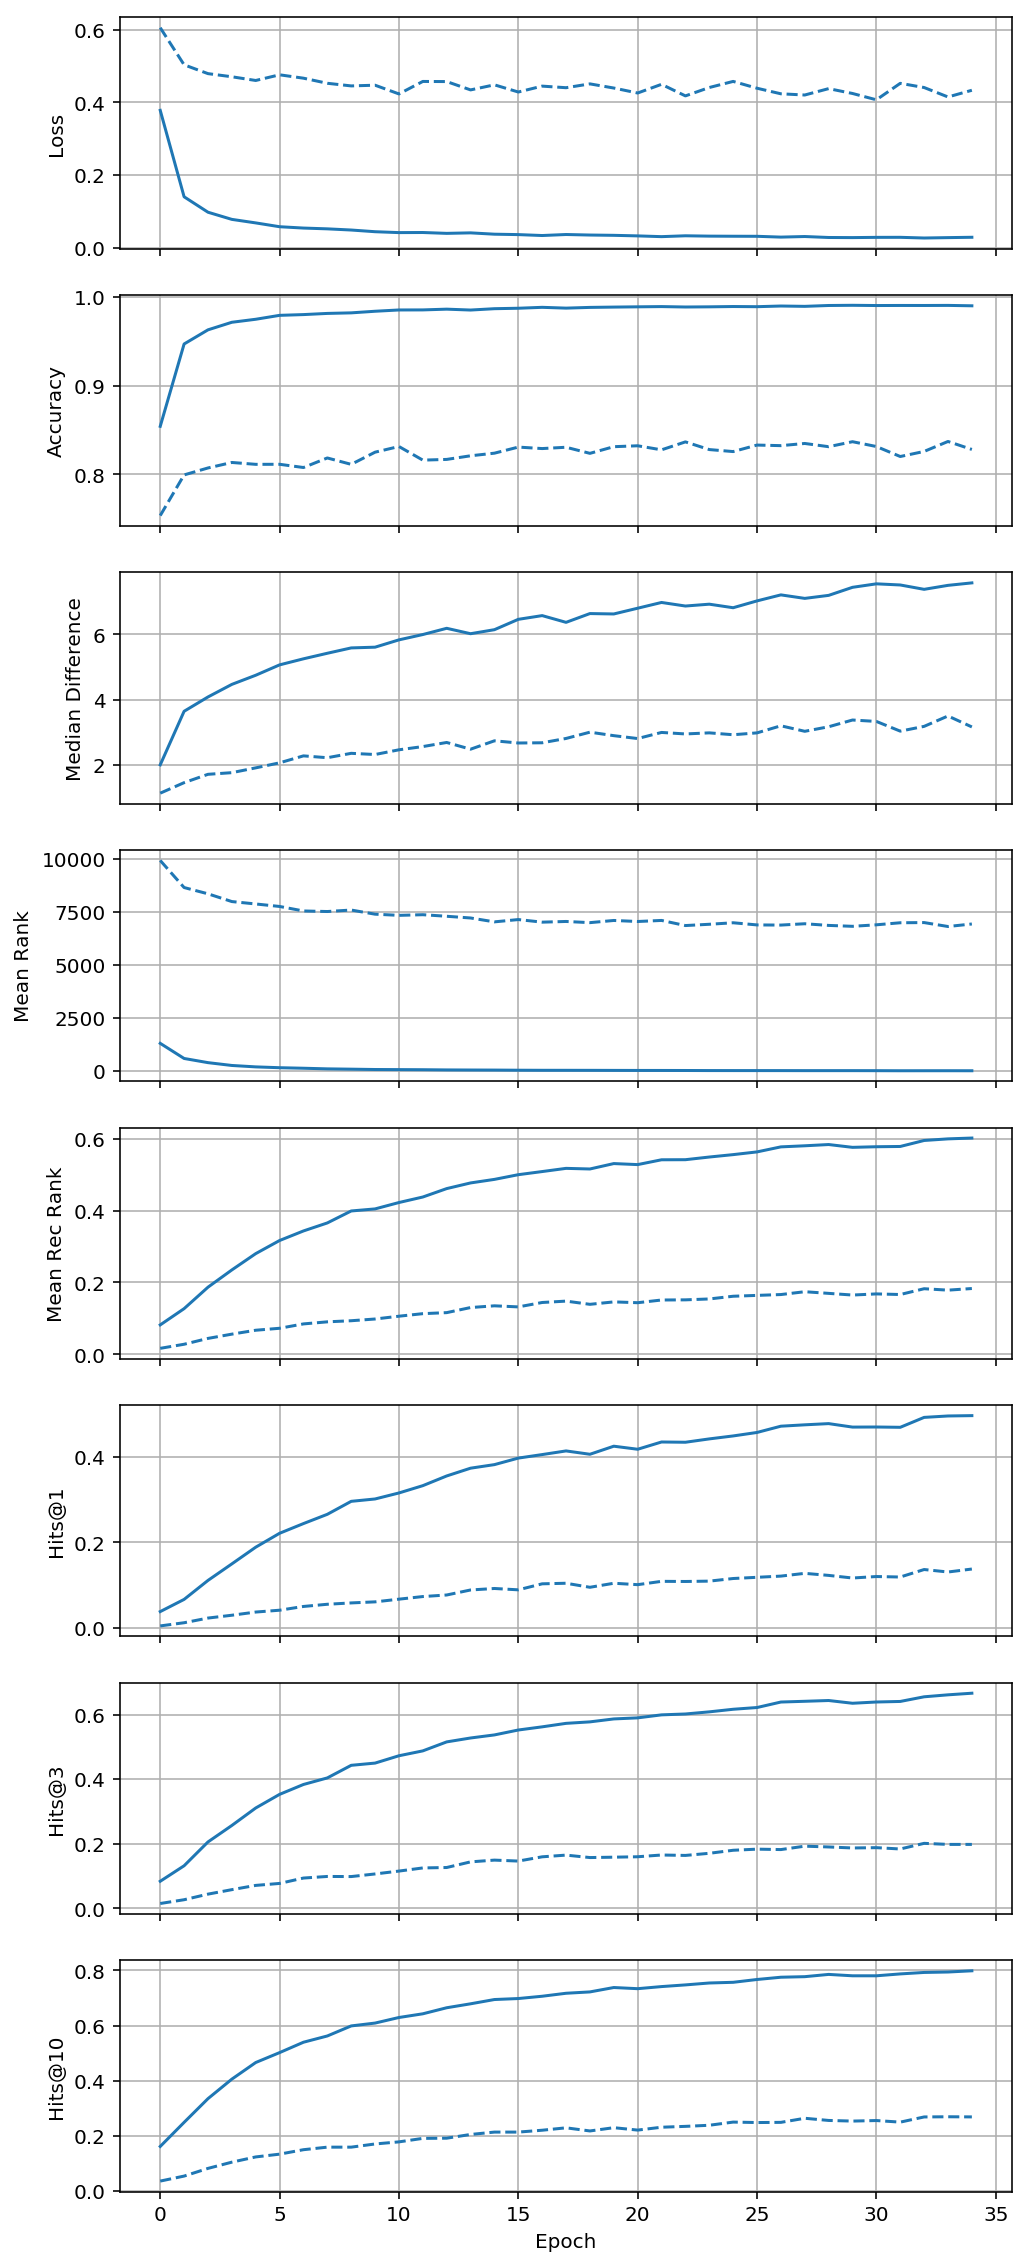

In [10]:
to_plot = ['loss', 'acc', 'median_diff', 'mean_rank', 'mean_rec_rank', 'hits_1', 'hits_3', 'hits_10']
figsize = (8, 20)

# TODO: Make fig legend for compare histories.
history.plot(*to_plot, figsize=figsize)#, xlim=(0, 10))

In [16]:
net.graph_conv1.num_sample_eval = None
net.graph_conv1.verbose = True
net.graph_conv2.num_sample_eval = None
net.eval()
val_ranker(embedding_func, scoring_func, batch_size=16)

Calculating embeddings for nodes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Got input_embeddings: Variable containing:
    1     0     0  ...      0     0     0
    0     1     0  ...      0     0     0
    0     0     1  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.cuda.FloatTensor of size 16x40943 (GPU 0)]

Multiplying them by weight matrix, preliminary output_embeddings are: Variable containing:
 0.1334  0.0238 -0.1099  ...   0.1603  0.0796  0.0263
-0.1874 -0.3205 -0.1564  ...  -0.0708 -0.2393 -0.0336
 0.0106  0.0791  0.1658  ...  -0.1493 -0.2272 -0.4199
          ...             ⋱             ...          
 0.1293  0.1232  0.0100  ...  -0.0842  0.0163  0.0082
-0.0634  0.0068  0.0477  ...   0.0703 -0.0196 -0.1093
 0.3457 -0.1508 -0.0009  ...   0.1099 -0.0027  0.0658
[torch.cuda.FloatTensor of size 16x200 (GPU 0)]



NameError: global name 'num_sample' is not defined

In [ ]:
%debug

> /home/jrieke/Projects/multimodal-gcn/layers.py(252)forward()
    250         unique_neighbors = list(set.union(*sampled_neighbors_per_node))
    251         unique_neighbors_to_index = {neighbor: i for i, neighbor in enumerate(unique_neighbors)}
--> 252         if self.verbose: print('Sampled', num_sample, 'neighbors per node. Unique neighbors are:', unique_neighbors)
    253 
    254         if not unique_neighbors:

ipdb> self.num_sample_eval
ipdb> self.num_sample_train
10
ipdb> self.training
False


In [20]:
!ls logs

10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv
11_dist-mult.tsv
12_rgcn_new-one-hot-embedding_raw-ranking.tsv
13-0_filtered-ranking_same-parameters-with-different-seeds.tsv
13-1_filtered-ranking_same-parameters-with-different-seeds.tsv
13-2_filtered-ranking_same-parameters-with-different-seeds.tsv
13-3_filtered-ranking_same-parameters-with-different-seeds.tsv
13-4_filtered-ranking_same-parameters-with-different-seeds.tsv
13-5_filtered-ranking_same-parameters-with-different-seeds.tsv
13-6_filtered-ranking_same-parameters-with-different-seeds.tsv
14-0_only-weight-initialization-seeded.tsv
14-1_only-weight-initialization-seeded.tsv
14-2_only-weight-initialization-seeded.tsv
14-3_only-weight-initialization-seeded.tsv
15-0_only-training-loop-seeded.tsv
15-1_only-training-loop-seeded.tsv
15-2_only-training-loop-seeded.tsv
15-3_only-training-loop-seeded.tsv
16-0_DistMult-unseeded.tsv
16-1_DistMult-unseeded.tsv
16-2_DistMult-unseeded.tsv
16-3_DistMult-unseeded.tsv
17-0_

In [21]:
#history.save('logs/30_image-features_ranking-training_history.tsv')

In [13]:
net.eval();
train_ranker(embedding_func, scoring_func, show_progress=True)

HBox(children=(IntProgress(value=0, max=5000), HTML(value=u'')))

(7135.27785, 0.004535485886334207, 0.0025, 0.0042, 0.007)

## Multiple training runs

In [7]:
num_runs = 2
force_cpu = False

for run in range(num_runs):
    base_name = 'logs/27-{}_average-ranking_elu_lr0.001'.format(run+1)
    
    # TODO: Increase embedding_size to 500 like in original paper.
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200, 
                           dist_mult_dropout=0.5, activation=F.elu)
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available() and not force_cpu:
        net.cuda()
        #print('Moved network to GPU')
    optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    # TODO: Increase batch_size and see if it changes results.
    batch_size = 64#32
    train_forward_kwargs = dict(num_sample=10)
    val_forward_kwargs = dict(num_sample=None)
    
    history = train_via_ranking(net, train_triples, val_triples, optimizer, num_nodes, train_ranker, val_ranker,
                                embedding_func, scoring_func, num_epochs=35, batch_size=batch_size, margin=1, 
                                train_forward_kwargs=train_forward_kwargs, val_forward_kwargs=val_forward_kwargs,
                                save_best_to=base_name + '_best-model_state-dict.pt')

    # TODO: Save history to json.
    history.save(base_name + '_history.tsv')

Initialized with OneHotEmbedding
Epoch 1/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.629528805328
Val Loss:   0.257045537233

Accuracy:       0.713467451305
Val Accuracy:   0.899743378162

Mean Difference:       1.18854869214
Val Mean Difference:   2.23171257973

Median Difference:       0.783057184507
Val Median Difference:   2.00336956978

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1055.83975
Val Mean Rank:   1367.8203878

Mean Rec Rank:       0.0915970638635
Val Mean Rec Rank:   0.0933443440108

Hits@1:       0.0584
Val Hits@1:   0.0602224123182

Hits@3:       0.0937
Val Hits@3:   0.0957798688338

Hits@10:       0.1535
Val Hits@10:   0.156030795552


Saving model after epoch 1 to logs/27-1_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 2/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.221113756853
Val Loss:   0.153331041336

Accuracy:       0.913509343356
Val Accuracy:   0.938694059849

Mean Difference:       2.93408906564
Val Mean Difference:   2.88972115517

Median Difference:       2.64697095508
Val Median Difference:   2.79693102837

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       612.82915
Val Mean Rank:   785.808283433

Mean Rec Rank:       0.110404432398
Val Mean Rec Rank:   0.117664927732

Hits@1:       0.0636
Val Hits@1:   0.0700598802395

Hits@3:       0.1178
Val Hits@3:   0.126689478186

Hits@10:       0.1973
Val Hits@10:   0.206586826347


Saving model after epoch 2 to logs/27-1_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 3/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.168735056517
Val Loss:   0.132316946983

Accuracy:       0.934443479886
Val Accuracy:   0.946449935436

Mean Difference:       3.34931860358
Val Mean Difference:   3.16799664497

Median Difference:       3.09865889466
Val Median Difference:   3.08898830414

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       493.4613
Val Mean Rank:   657.832848589

Mean Rec Rank:       0.129751417846
Val Mean Rec Rank:   0.138091557433

Hits@1:       0.078
Val Hits@1:   0.0847162817223

Hits@3:       0.1378
Val Hits@3:   0.149558026804

Hits@10:       0.2271
Val Hits@10:   0.238637011691


Saving model after epoch 3 to logs/27-1_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 4/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.147457313817
Val Loss:   0.120966382325

Accuracy:       0.943072709152
Val Accuracy:   0.950156807899

Mean Difference:       3.56924238574
Val Mean Difference:   3.40806913376

Median Difference:       3.34110553525
Val Median Difference:   3.34774804115

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       442.07525
Val Mean Rank:   597.281209011

Mean Rec Rank:       0.131646725826
Val Mean Rec Rank:   0.139770690569

Hits@1:       0.0751
Val Hits@1:   0.0823210721414

Hits@3:       0.1392
Val Hits@3:   0.15255203878

Hits@10:       0.2424
Val Hits@10:   0.252380952381


Saving model after epoch 4 to logs/27-1_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 5/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.137621197759
Val Loss:   0.113076619804

Accuracy:       0.947005546987
Val Accuracy:   0.954262912273

Mean Difference:       3.72748195015
Val Mean Difference:   3.52079129219

Median Difference:       3.49939269601
Val Median Difference:   3.45471429825

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       405.6193
Val Mean Rank:   548.459495295

Mean Rec Rank:       0.129837298199
Val Mean Rec Rank:   0.14255773612

Hits@1:       0.0746
Val Hits@1:   0.0861134873111

Hits@3:       0.1352
Val Hits@3:   0.150698602794

Hits@10:       0.2379
Val Hits@10:   0.255460507556


Saving model after epoch 5 to logs/27-1_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 6/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.128767511056
Val Loss:   0.112026616931

Accuracy:       0.950472701429
Val Accuracy:   0.952495038509

Mean Difference:       3.8613193159
Val Mean Difference:   3.59380030632

Median Difference:       3.62356812244
Val Median Difference:   3.50531697273

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       368.3218
Val Mean Rank:   522.363800969

Mean Rec Rank:       0.131396293888
Val Mean Rec Rank:   0.143202118119

Hits@1:       0.0738
Val Hits@1:   0.0841459937268

Hits@3:       0.1379
Val Hits@3:   0.155146849159

Hits@10:       0.2464
Val Hits@10:   0.259623609923


Saving model after epoch 6 to logs/27-1_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 7/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.120970061812
Val Loss:   0.109076343477

Accuracy:       0.953366596227
Val Accuracy:   0.955802679062

Mean Difference:       4.05093577827
Val Mean Difference:   3.70339655876

Median Difference:       3.79651853153
Val Median Difference:   3.67226791382

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       350.90485
Val Mean Rank:   501.378029655

Mean Rec Rank:       0.141120756186
Val Mean Rec Rank:   0.147235306218

Hits@1:       0.0832
Val Hits@1:   0.0873396065013

Hits@3:       0.1493
Val Hits@3:   0.159252922726

Hits@10:       0.2496
Val Hits@10:   0.263615625891


Saving model after epoch 7 to logs/27-1_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 8/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.116445275291
Val Loss:   0.106042042375

Accuracy:       0.955599902238
Val Accuracy:   0.955688595772

Mean Difference:       4.17143317903
Val Mean Difference:   3.81937193871

Median Difference:       3.90682971119
Val Median Difference:   3.73710179329

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       335.1052
Val Mean Rank:   494.373467351

Mean Rec Rank:       0.152958717724
Val Mean Rec Rank:   0.161040649981

Hits@1:       0.0927
Val Hits@1:   0.10125463359

Hits@3:       0.1622
Val Hits@3:   0.174850299401

Hits@10:       0.2699
Val Hits@10:   0.277701739378


Saving model after epoch 8 to logs/27-1_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 9/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.113905747673
Val Loss:   0.102965116501

Accuracy:       0.956265030413
Val Accuracy:   0.95745652914

Mean Difference:       4.21963609869
Val Mean Difference:   3.79521179199

Median Difference:       3.95219547291
Val Median Difference:   3.74464416504

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       317.1985
Val Mean Rank:   467.493969204

Mean Rec Rank:       0.157436771023
Val Mean Rec Rank:   0.165691972291

Hits@1:       0.0979
Val Hits@1:   0.104704875962

Hits@3:       0.1677
Val Hits@3:   0.179469632164

Hits@10:       0.2734
Val Hits@10:   0.281380096949


Saving model after epoch 9 to logs/27-1_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 10/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.110504334198
Val Loss:   0.0974588692188

Accuracy:       0.957543840385
Val Accuracy:   0.958939254284

Mean Difference:       4.31329394777
Val Mean Difference:   3.96492958069

Median Difference:       4.03337237634
Val Median Difference:   3.90076780319

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       304.14115
Val Mean Rank:   459.268976333

Mean Rec Rank:       0.154381599448
Val Mean Rec Rank:   0.160131723454

Hits@1:       0.0919
Val Hits@1:   0.0985457656116

Hits@3:       0.1637
Val Hits@3:   0.172198460222

Hits@10:       0.2763
Val Hits@10:   0.283233532934

--------------------------------------------------------------------------------

Epoch 11/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.10813524987
Val Loss:   0.0992765203118

Accuracy:       0.958860262415
Val Accuracy:   0.959224402905

Mean Difference:       4.45672213605
Val Mean Difference:   3.97742462158

Median Difference:       4.15093805789
Val Median Difference:   3.85884332657

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       295.2869
Val Mean Rank:   448.533746792

Mean Rec Rank:       0.151340205082
Val Mean Rec Rank:   0.15567598713

Hits@1:       0.0852
Val Hits@1:   0.0906472768748

Hits@3:       0.1635
Val Hits@3:   0.171400057029

Hits@10:       0.2772
Val Hits@10:   0.278414599373

--------------------------------------------------------------------------------

Epoch 12/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.106156609321
Val Loss:   0.094128459692

Accuracy:       0.959604433555
Val Accuracy:   0.961049318314

Mean Difference:       4.47856157166
Val Mean Difference:   4.15839147568

Median Difference:       4.16440669266
Val Median Difference:   4.06383037567

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       286.522
Val Mean Rank:   440.792999715

Mean Rec Rank:       0.155876129099
Val Mean Rec Rank:   0.159175957216

Hits@1:       0.0878
Val Hits@1:   0.0941830624465

Hits@3:       0.169
Val Hits@3:   0.173681209011

Hits@10:       0.2883
Val Hits@10:   0.283404619333

--------------------------------------------------------------------------------

Epoch 13/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.10580999553
Val Loss:   0.0904225930572

Accuracy:       0.960193328861
Val Accuracy:   0.96378672123

Mean Difference:       4.54781621908
Val Mean Difference:   4.17709827423

Median Difference:       4.22829715211
Val Median Difference:   4.03448963165

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       275.7333
Val Mean Rank:   425.006786427

Mean Rec Rank:       0.159871067326
Val Mean Rec Rank:   0.164930477191

Hits@1:       0.0915
Val Hits@1:   0.0997148560023

Hits@3:       0.1757
Val Hits@3:   0.181123467351

Hits@10:       0.289
Val Hits@10:   0.289905902481

--------------------------------------------------------------------------------

Epoch 14/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.102463240299
Val Loss:   0.091644756496

Accuracy:       0.961175421486
Val Accuracy:   0.960821211338

Mean Difference:       4.6596563159
Val Mean Difference:   4.23226308823

Median Difference:       4.32220878706
Val Median Difference:   4.06560516357

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       270.26555
Val Mean Rank:   422.985571714

Mean Rec Rank:       0.164700731683
Val Mean Rec Rank:   0.172498080325

Hits@1:       0.0958
Val Hits@1:   0.109096093527

Hits@3:       0.181
Val Hits@3:   0.187653264899

Hits@10:       0.2942
Val Hits@10:   0.295494724836


Saving model after epoch 14 to logs/27-1_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 15/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.100598473573
Val Loss:   0.0906761363149

Accuracy:       0.961918655927
Val Accuracy:   0.962132871151

Mean Difference:       4.72766655224
Val Mean Difference:   4.19223546982

Median Difference:       4.38198584514
Val Median Difference:   4.0122089386

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       262.2215
Val Mean Rank:   419.846963216

Mean Rec Rank:       0.167637714729
Val Mean Rec Rank:   0.171278807019

Hits@1:       0.1004
Val Hits@1:   0.106786427146

Hits@3:       0.181
Val Hits@3:   0.186655260907

Hits@10:       0.2962
Val Hits@10:   0.294011976048

--------------------------------------------------------------------------------

Epoch 16/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.100223847488
Val Loss:   0.094775877893

Accuracy:       0.962097709499
Val Accuracy:   0.960479021072

Mean Difference:       4.77586352898
Val Mean Difference:   4.37387037277

Median Difference:       4.40927634521
Val Median Difference:   4.19909334183

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       260.9139
Val Mean Rank:   412.591132022

Mean Rec Rank:       0.170778109653
Val Mean Rec Rank:   0.172163357455

Hits@1:       0.1064
Val Hits@1:   0.109580838323

Hits@3:       0.1815
Val Hits@3:   0.186370116909

Hits@10:       0.2967
Val Hits@10:   0.294667807243

--------------------------------------------------------------------------------

Epoch 17/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0985700155287
Val Loss:   0.0887473225594

Accuracy:       0.963286524335
Val Accuracy:   0.962475061417

Mean Difference:       4.85557011188
Val Mean Difference:   4.47577285767

Median Difference:       4.47915065261
Val Median Difference:   4.2780585289

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       257.3656
Val Mean Rank:   406.959837468

Mean Rec Rank:       0.164208305602
Val Mean Rec Rank:   0.167446694668

Hits@1:       0.0948
Val Hits@1:   0.100940975192

Hits@3:       0.1791
Val Hits@3:   0.18377530653

Hits@10:       0.2938
Val Hits@10:   0.297433704021

--------------------------------------------------------------------------------

Epoch 18/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0971078529241
Val Loss:   0.0897919759154

Accuracy:       0.963326081844
Val Accuracy:   0.963387489319

Mean Difference:       4.95773537481
Val Mean Difference:   4.54761171341

Median Difference:       4.56055342316
Val Median Difference:   4.33748722076

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       249.8313
Val Mean Rank:   409.941844882

Mean Rec Rank:       0.169075056853
Val Mean Rec Rank:   0.169475132491

Hits@1:       0.0996
Val Hits@1:   0.104020530368

Hits@3:       0.1813
Val Hits@3:   0.183860849729

Hits@10:       0.3074
Val Hits@10:   0.297405189621

--------------------------------------------------------------------------------

Epoch 19/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0974471563174
Val Loss:   0.0919148996472

Accuracy:       0.963332494628
Val Accuracy:   0.962703168392

Mean Difference:       4.97848381389
Val Mean Difference:   4.43894433975

Median Difference:       4.57491429252
Val Median Difference:   4.22734117508

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       244.016
Val Mean Rank:   402.623652695

Mean Rec Rank:       0.166073665379
Val Mean Rec Rank:   0.167839017786

Hits@1:       0.0976
Val Hits@1:   0.102765896778

Hits@3:       0.1793
Val Hits@3:   0.182064442543

Hits@10:       0.2994
Val Hits@10:   0.29381237525

--------------------------------------------------------------------------------

Epoch 20/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0972222322044
Val Loss:   0.0912431329489

Accuracy:       0.963778939669
Val Accuracy:   0.961505532265

Mean Difference:       5.08165662253
Val Mean Difference:   4.60957193375

Median Difference:       4.65762264338
Val Median Difference:   4.37183713913

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       239.3147
Val Mean Rank:   397.733732535

Mean Rec Rank:       0.16199183636
Val Mean Rec Rank:   0.167301088339

Hits@1:       0.0915
Val Hits@1:   0.100199600798

Hits@3:       0.1737
Val Hits@3:   0.184117479327

Hits@10:       0.3009
Val Hits@10:   0.29623609923

--------------------------------------------------------------------------------

Epoch 21/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0970571878268
Val Loss:   0.0916130468249

Accuracy:       0.964012321768
Val Accuracy:   0.962018847466

Mean Difference:       5.09346997609
Val Mean Difference:   4.63042879105

Median Difference:       4.6725725328
Val Median Difference:   4.38561248779

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       236.0894
Val Mean Rank:   396.861790704

Mean Rec Rank:       0.169503749666
Val Mean Rec Rank:   0.169369006045

Hits@1:       0.0999
Val Hits@1:   0.104077559167

Hits@3:       0.1841
Val Hits@3:   0.183604220131

Hits@10:       0.3066
Val Hits@10:   0.296834901625

--------------------------------------------------------------------------------

Epoch 22/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0948347417379
Val Loss:   0.0866475850344

Accuracy:       0.964364160234
Val Accuracy:   0.964756190777

Mean Difference:       5.17402422002
Val Mean Difference:   4.65223121643

Median Difference:       4.72169794788
Val Median Difference:   4.39683437347

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       229.73055
Val Mean Rank:   395.075648703

Mean Rec Rank:       0.16932937585
Val Mean Rec Rank:   0.171992271475

Hits@1:       0.0994
Val Hits@1:   0.104106073567

Hits@3:       0.18
Val Hits@3:   0.188195038494

Hits@10:       0.3102
Val Hits@10:   0.30376390077

--------------------------------------------------------------------------------

Epoch 23/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0940125470141
Val Loss:   0.0877880901098

Accuracy:       0.964966817807
Val Accuracy:   0.962931275368

Mean Difference:       5.24178275087
Val Mean Difference:   4.72120428085

Median Difference:       4.78269148125
Val Median Difference:   4.48712396622

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       222.28125
Val Mean Rank:   389.012303964

Mean Rec Rank:       0.170882291106
Val Mean Rec Rank:   0.172278772219

Hits@1:       0.1
Val Hits@1:   0.104619332763

Hits@3:       0.1847
Val Hits@3:   0.187225548902

Hits@10:       0.3078
Val Hits@10:   0.307014542344

--------------------------------------------------------------------------------

Epoch 24/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0939055411625
Val Loss:   0.0850977525115

Accuracy:       0.965231399181
Val Accuracy:   0.964242935181

Mean Difference:       5.25363468877
Val Mean Difference:   4.76106834412

Median Difference:       4.78796443094
Val Median Difference:   4.51017856598

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       223.70135
Val Mean Rank:   383.639378386

Mean Rec Rank:       0.172734785301
Val Mean Rec Rank:   0.173578623361

Hits@1:       0.0994
Val Hits@1:   0.10376390077

Hits@3:       0.1878
Val Hits@3:   0.192956943256

Hits@10:       0.3164
Val Hits@10:   0.30752780154


Saving model after epoch 24 to logs/27-1_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 25/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0934659056723
Val Loss:   0.083943657577

Accuracy:       0.965189175682
Val Accuracy:   0.965383529663

Mean Difference:       5.33920747658
Val Mean Difference:   4.70694971085

Median Difference:       4.8469785407
Val Median Difference:   4.39353275299

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       216.7361
Val Mean Rank:   374.289592244

Mean Rec Rank:       0.173388031621
Val Mean Rec Rank:   0.174986369833

Hits@1:       0.1031
Val Hits@1:   0.107185628743

Hits@3:       0.1864
Val Hits@3:   0.190447676076

Hits@10:       0.3147
Val Hits@10:   0.309381237525


Saving model after epoch 25 to logs/27-1_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 26/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0934051129021
Val Loss:   0.0867813304067

Accuracy:       0.965316854929
Val Accuracy:   0.964014828205

Mean Difference:       5.33211828097
Val Mean Difference:   4.88635158539

Median Difference:       4.83519842147
Val Median Difference:   4.58209657669

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       217.9147
Val Mean Rank:   378.392044482

Mean Rec Rank:       0.167903655756
Val Mean Rec Rank:   0.1697718247

Hits@1:       0.0935
Val Hits@1:   0.100199600798

Hits@3:       0.1828
Val Hits@3:   0.187767322498

Hits@10:       0.3131
Val Hits@10:   0.307043056744

--------------------------------------------------------------------------------

Epoch 27/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0931010344083
Val Loss:   0.0881314650178

Accuracy:       0.965486757675
Val Accuracy:   0.963900744915

Mean Difference:       5.41946488821
Val Mean Difference:   4.73793411255

Median Difference:       4.9170726305
Val Median Difference:   4.44621229172

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       217.4182
Val Mean Rank:   376.335443399

Mean Rec Rank:       0.172857763893
Val Mean Rec Rank:   0.172066032229

Hits@1:       0.0999
Val Hits@1:   0.10373538637

Hits@3:       0.1896
Val Hits@3:   0.188964927288

Hits@10:       0.3168
Val Hits@10:   0.306016538352

--------------------------------------------------------------------------------

Epoch 28/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.093142049084
Val Loss:   0.0883923992515

Accuracy:       0.965756887186
Val Accuracy:   0.964299976826

Mean Difference:       5.489743902
Val Mean Difference:   4.87617826462

Median Difference:       4.96305635109
Val Median Difference:   4.53888177872

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       210.28545
Val Mean Rank:   365.932520673

Mean Rec Rank:       0.175396736608
Val Mean Rec Rank:   0.172821581579

Hits@1:       0.1022
Val Hits@1:   0.102965497576

Hits@3:       0.192
Val Hits@3:   0.191074992871

Hits@10:       0.3189
Val Hits@10:   0.309181636727

--------------------------------------------------------------------------------

Epoch 29/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0911961942997
Val Loss:   0.0840452834964

Accuracy:       0.966127099359
Val Accuracy:   0.964414000511

Mean Difference:       5.54148542152
Val Mean Difference:   5.00221776962

Median Difference:       5.01126234658
Val Median Difference:   4.68302345276

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       212.4567
Val Mean Rank:   366.41471343

Mean Rec Rank:       0.174343341372
Val Mean Rec Rank:   0.177187680665

Hits@1:       0.1005
Val Hits@1:   0.109153122327

Hits@3:       0.1897
Val Hits@3:   0.193669803251

Hits@10:       0.3159
Val Hits@10:   0.309865982321


Saving model after epoch 29 to logs/27-1_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 30/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0908829284438
Val Loss:   0.082208417356

Accuracy:       0.966291526019
Val Accuracy:   0.965155422688

Mean Difference:       5.6078367725
Val Mean Difference:   4.94737243652

Median Difference:       5.05333038057
Val Median Difference:   4.60103988647

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       212.0325
Val Mean Rank:   364.141374394

Mean Rec Rank:       0.172706502441
Val Mean Rec Rank:   0.173170638819

Hits@1:       0.0985
Val Hits@1:   0.101796407186

Hits@3:       0.1882
Val Hits@3:   0.193042486456

Hits@10:       0.3162
Val Hits@10:   0.310350727117

--------------------------------------------------------------------------------

Epoch 31/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0916386343504
Val Loss:   0.0849052071571

Accuracy:       0.966087613903
Val Accuracy:   0.96618193388

Mean Difference:       5.5296801443
Val Mean Difference:   4.93062543869

Median Difference:       4.95733800006
Val Median Difference:   4.60026073456

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       208.8914
Val Mean Rank:   364.551810664

Mean Rec Rank:       0.17411663541
Val Mean Rec Rank:   0.175015391875

Hits@1:       0.1036
Val Hits@1:   0.107641859139

Hits@3:       0.1843
Val Hits@3:   0.188309096094

Hits@10:       0.3147
Val Hits@10:   0.308468776732

--------------------------------------------------------------------------------

Epoch 32/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0901676821947
Val Loss:   0.0815678760409

Accuracy:       0.966911692652
Val Accuracy:   0.967436552048

Mean Difference:       5.67253254196
Val Mean Difference:   5.08977985382

Median Difference:       5.08606213757
Val Median Difference:   4.67771244049

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       205.5069
Val Mean Rank:   356.865896778

Mean Rec Rank:       0.174135912455
Val Mean Rec Rank:   0.175326166207

Hits@1:       0.0999
Val Hits@1:   0.107014542344

Hits@3:       0.1867
Val Hits@3:   0.18873681209

Hits@10:       0.3217
Val Hits@10:   0.310664385515

--------------------------------------------------------------------------------

Epoch 33/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0908455764765
Val Loss:   0.0843517035246

Accuracy:       0.966931867703
Val Accuracy:   0.964870274067

Mean Difference:       5.65686802189
Val Mean Difference:   4.85465049744

Median Difference:       5.0562698129
Val Median Difference:   4.47725296021

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       205.26275
Val Mean Rank:   358.111833476

Mean Rec Rank:       0.175688959308
Val Mean Rec Rank:   0.172931045774

Hits@1:       0.0993
Val Hits@1:   0.101482748788

Hits@3:       0.1922
Val Hits@3:   0.190162532079

Hits@10:       0.323
Val Hits@10:   0.313658397491

--------------------------------------------------------------------------------

Epoch 34/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0903346580116
Val Loss:   0.0854048579931

Accuracy:       0.966841872568
Val Accuracy:   0.964585125446

Mean Difference:       5.7272355607
Val Mean Difference:   4.99827957153

Median Difference:       5.11447850142
Val Median Difference:   4.56358671188

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       206.4355
Val Mean Rank:   354.251468492

Mean Rec Rank:       0.175089954609
Val Mean Rec Rank:   0.176403680623

Hits@1:       0.1002
Val Hits@1:   0.107841459937

Hits@3:       0.1906
Val Hits@3:   0.191046478472

Hits@10:       0.3248
Val Hits@10:   0.313629883091

--------------------------------------------------------------------------------

Epoch 35/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0893255704217
Val Loss:   0.0854501649737

Accuracy:       0.967090818278
Val Accuracy:   0.964756190777

Mean Difference:       5.8412488949
Val Mean Difference:   5.14592838287

Median Difference:       5.17884531323
Val Median Difference:   4.69478178024

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       197.96095
Val Mean Rank:   353.042343884

Mean Rec Rank:       0.178083875754
Val Mean Rec Rank:   0.176534956148

Hits@1:       0.1007
Val Hits@1:   0.10755631594

Hits@3:       0.1945
Val Hits@3:   0.191816367265

Hits@10:       0.3322
Val Hits@10:   0.312774451098

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Epoch 1/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.593707250925
Val Loss:   0.237147912383

Accuracy:       0.732066253714
Val Accuracy:   0.904704868793

Mean Difference:       1.36627290098
Val Mean Difference:   2.52062702179

Median Difference:       0.967217044257
Val Median Difference:   2.24009442329

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       962.6415
Val Mean Rank:   1214.62358141

Mean Rec Rank:       0.0811733502756
Val Mean Rec Rank:   0.0801019793154

Hits@1:       0.0466
Val Hits@1:   0.0459366980325

Hits@3:       0.0825
Val Hits@3:   0.0810949529512

Hits@10:       0.1469
Val Hits@10:   0.14502423724


Saving model after epoch 1 to logs/27-2_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 2/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.212180996092
Val Loss:   0.153928756714

Accuracy:       0.917331146358
Val Accuracy:   0.937895655632

Mean Difference:       3.08968696876
Val Mean Difference:   2.99958992004

Median Difference:       2.74880282064
Val Median Difference:   2.86877894402

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       606.9024
Val Mean Rank:   771.570287995

Mean Rec Rank:       0.108390027436
Val Mean Rec Rank:   0.111979202007

Hits@1:       0.0635
Val Hits@1:   0.0683205018534

Hits@3:       0.1133
Val Hits@3:   0.117564870259

Hits@10:       0.193
Val Hits@10:   0.194582264043


Saving model after epoch 2 to logs/27-2_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 3/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.166239102803
Val Loss:   0.133158132434

Accuracy:       0.93557249011
Val Accuracy:   0.946678102016

Mean Difference:       3.40762806281
Val Mean Difference:   3.21188259125

Median Difference:       3.12374968158
Val Median Difference:   3.12563323975

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       496.5452
Val Mean Rank:   654.938294839

Mean Rec Rank:       0.111649433654
Val Mean Rec Rank:   0.120020017832

Hits@1:       0.065
Val Hits@1:   0.0723125178215

Hits@3:       0.113
Val Hits@3:   0.124208725406

Hits@10:       0.2047
Val Hits@10:   0.214913031081


Saving model after epoch 3 to logs/27-2_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 4/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.14663580005
Val Loss:   0.12351641804

Accuracy:       0.943732289189
Val Accuracy:   0.949586570263

Mean Difference:       3.62173472007
Val Mean Difference:   3.45490908623

Median Difference:       3.37386341725
Val Median Difference:   3.36205053329

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       433.73975
Val Mean Rank:   594.549985743

Mean Rec Rank:       0.124126132096
Val Mean Rec Rank:   0.130855542985

Hits@1:       0.0722
Val Hits@1:   0.078500142572

Hits@3:       0.13
Val Hits@3:   0.139520958084

Hits@10:       0.2233
Val Hits@10:   0.23370402053


Saving model after epoch 4 to logs/27-2_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 5/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.135518389488
Val Loss:   0.11125022918

Accuracy:       0.947945416114
Val Accuracy:   0.955460488796

Mean Difference:       3.7593749973
Val Mean Difference:   3.5594098568

Median Difference:       3.51121130661
Val Median Difference:   3.47661471367

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       395.0249
Val Mean Rank:   554.510293698

Mean Rec Rank:       0.137195860328
Val Mean Rec Rank:   0.142872792966

Hits@1:       0.0835
Val Hits@1:   0.0893926432849

Hits@3:       0.1459
Val Hits@3:   0.152894211577

Hits@10:       0.2384
Val Hits@10:   0.243997718848


Saving model after epoch 5 to logs/27-2_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 6/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.127144363691
Val Loss:   0.113048538566

Accuracy:       0.951287557298
Val Accuracy:   0.952380955219

Mean Difference:       3.92150110662
Val Mean Difference:   3.45884156227

Median Difference:       3.65813386939
Val Median Difference:   3.38544511795

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       368.6945
Val Mean Rank:   531.821970345

Mean Rec Rank:       0.135484043152
Val Mean Rec Rank:   0.139224553521

Hits@1:       0.0789
Val Hits@1:   0.0835757057314

Hits@3:       0.1443
Val Hits@3:   0.147419446821

Hits@10:       0.2427
Val Hits@10:   0.250128314799

--------------------------------------------------------------------------------

Epoch 7/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.122474324579
Val Loss:   0.106153488159

Accuracy:       0.953519061965
Val Accuracy:   0.955289423466

Mean Difference:       3.9826168594
Val Mean Difference:   3.73608493805

Median Difference:       3.72711754905
Val Median Difference:   3.67212295532

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       349.1738
Val Mean Rank:   510.901910465

Mean Rec Rank:       0.143705266572
Val Mean Rec Rank:   0.142623082346

Hits@1:       0.0852
Val Hits@1:   0.0840889649273

Hits@3:       0.1515
Val Hits@3:   0.154605075563

Hits@10:       0.2574
Val Hits@10:   0.256829198745

--------------------------------------------------------------------------------

Epoch 8/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.117568502873
Val Loss:   0.101483590901

Accuracy:       0.955092787939
Val Accuracy:   0.957855701447

Mean Difference:       4.12224518227
Val Mean Difference:   3.80992889404

Median Difference:       3.84821934657
Val Median Difference:   3.72343492508

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       330.15185
Val Mean Rank:   483.854662104

Mean Rec Rank:       0.145058506961
Val Mean Rec Rank:   0.149934088684

Hits@1:       0.0849
Val Hits@1:   0.0915882520673

Hits@3:       0.1557
Val Hits@3:   0.16122041631

Hits@10:       0.2597
Val Hits@10:   0.262703165098


Saving model after epoch 8 to logs/27-2_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 9/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.112198777852
Val Loss:   0.09832752496

Accuracy:       0.957274647572
Val Accuracy:   0.959338486195

Mean Difference:       4.22259408342
Val Mean Difference:   3.88306641579

Median Difference:       3.95594039125
Val Median Difference:   3.78621864319

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       317.85595
Val Mean Rank:   471.450513259

Mean Rec Rank:       0.156466159426
Val Mean Rec Rank:   0.15660593868

Hits@1:       0.0951
Val Hits@1:   0.0961790704306

Hits@3:       0.1696
Val Hits@3:   0.169632164243

Hits@10:       0.2689
Val Hits@10:   0.272768748218


Saving model after epoch 9 to logs/27-2_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 10/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.109133074084
Val Loss:   0.101860187948

Accuracy:       0.958127187553
Val Accuracy:   0.95717138052

Mean Difference:       4.35577986208
Val Mean Difference:   3.95459794998

Median Difference:       4.07062382442
Val Median Difference:   3.87816619873

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       308.333
Val Mean Rank:   460.326561163

Mean Rec Rank:       0.151229223333
Val Mean Rec Rank:   0.154371270228

Hits@1:       0.0902
Val Hits@1:   0.0904476760764

Hits@3:       0.1599
Val Hits@3:   0.169888793841

Hits@10:       0.2693
Val Hits@10:   0.276817792985

--------------------------------------------------------------------------------

Epoch 11/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.108680029514
Val Loss:   0.0971748754382

Accuracy:       0.958611316706
Val Accuracy:   0.960079848766

Mean Difference:       4.37701421146
Val Mean Difference:   3.9900765419

Median Difference:       4.0925563446
Val Median Difference:   3.91460132599

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       300.6343
Val Mean Rank:   445.747362418

Mean Rec Rank:       0.154265024419
Val Mean Rec Rank:   0.15549658721

Hits@1:       0.0898
Val Hits@1:   0.0892785856858

Hits@3:       0.1648
Val Hits@3:   0.171086398631

Hits@10:       0.2819
Val Hits@10:   0.287795836898

--------------------------------------------------------------------------------

Epoch 12/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.106543002118
Val Loss:   0.095319993794

Accuracy:       0.959756971345
Val Accuracy:   0.960250914097

Mean Difference:       4.45597157093
Val Mean Difference:   4.14768075943

Median Difference:       4.17110440413
Val Median Difference:   4.0117149353

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       287.8909
Val Mean Rank:   441.631422869

Mean Rec Rank:       0.154943368092
Val Mean Rec Rank:   0.155439798776

Hits@1:       0.0893
Val Hits@1:   0.0894781864842

Hits@3:       0.168
Val Hits@3:   0.170402053037

Hits@10:       0.282
Val Hits@10:   0.28502994012

--------------------------------------------------------------------------------

Epoch 13/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.104426618716
Val Loss:   0.0887780562043

Accuracy:       0.960288872135
Val Accuracy:   0.963501572609

Mean Difference:       4.60267665279
Val Mean Difference:   4.1640291214

Median Difference:       4.26990921001
Val Median Difference:   4.00442838669

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       279.2987
Val Mean Rank:   436.251511263

Mean Rec Rank:       0.163669622548
Val Mean Rec Rank:   0.165100980668

Hits@1:       0.0997
Val Hits@1:   0.104106073567

Hits@3:       0.1742
Val Hits@3:   0.177388080981

Hits@10:       0.2882
Val Hits@10:   0.284145993727


Saving model after epoch 13 to logs/27-2_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 14/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.102211936105
Val Loss:   0.0988408401608

Accuracy:       0.9612112322
Val Accuracy:   0.960193872452

Mean Difference:       4.65112038138
Val Mean Difference:   4.28851366043

Median Difference:       4.32114538834
Val Median Difference:   4.15471553802

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       271.9598
Val Mean Rank:   424.201853436

Mean Rec Rank:       0.167099040795
Val Mean Rec Rank:   0.165333891665

Hits@1:       0.1021
Val Hits@1:   0.102195608782

Hits@3:       0.1786
Val Hits@3:   0.179127459367

Hits@10:       0.2914
Val Hits@10:   0.289021956088


Saving model after epoch 14 to logs/27-2_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 15/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0993434559161
Val Loss:   0.095965526998

Accuracy:       0.962138203706
Val Accuracy:   0.960536062717

Mean Difference:       4.7402658042
Val Mean Difference:   4.22554969788

Median Difference:       4.38925750247
Val Median Difference:   4.09105443954

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       263.55355
Val Mean Rank:   421.569118905

Mean Rec Rank:       0.168115311234
Val Mean Rec Rank:   0.168115797818

Hits@1:       0.1018
Val Hits@1:   0.104904476761

Hits@3:       0.1803
Val Hits@3:   0.181380096949

Hits@10:       0.2978
Val Hits@10:   0.292015968064


Saving model after epoch 15 to logs/27-2_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 16/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.100656248071
Val Loss:   0.0981190055609

Accuracy:       0.961874486978
Val Accuracy:   0.958597064018

Mean Difference:       4.75722942628
Val Mean Difference:   4.24481344223

Median Difference:       4.40930418674
Val Median Difference:   4.08551216125

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       259.9043
Val Mean Rank:   419.093755346

Mean Rec Rank:       0.167442869332
Val Mean Rec Rank:   0.166317907462

Hits@1:       0.0994
Val Hits@1:   0.101511263188

Hits@3:       0.1812
Val Hits@3:   0.183005417736

Hits@10:       0.3006
Val Hits@10:   0.288423153693

--------------------------------------------------------------------------------

Epoch 17/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0991396351366
Val Loss:   0.0900397077203

Accuracy:       0.962376125192
Val Accuracy:   0.962931275368

Mean Difference:       4.75201884027
Val Mean Difference:   4.30658388138

Median Difference:       4.3940732538
Val Median Difference:   4.12376880646

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       256.3416
Val Mean Rank:   412.100156829

Mean Rec Rank:       0.16484316559
Val Mean Rec Rank:   0.162576501215

Hits@1:       0.0945
Val Hits@1:   0.0968634160251

Hits@3:       0.1804
Val Hits@3:   0.177929854577

Hits@10:       0.3035
Val Hits@10:   0.289706301682

--------------------------------------------------------------------------------

Epoch 18/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0967908029691
Val Loss:   0.0875529125333

Accuracy:       0.96387635634
Val Accuracy:   0.964299976826

Mean Difference:       4.88262542676
Val Mean Difference:   4.34099006653

Median Difference:       4.5061256779
Val Median Difference:   4.17648792267

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       249.66285
Val Mean Rank:   405.491602509

Mean Rec Rank:       0.16696737163
Val Mean Rec Rank:   0.163413478433

Hits@1:       0.0981
Val Hits@1:   0.098003992016

Hits@3:       0.1811
Val Hits@3:   0.17747362418

Hits@10:       0.2971
Val Hits@10:   0.290419161677

--------------------------------------------------------------------------------

Epoch 19/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0956084096689
Val Loss:   0.0917961150408

Accuracy:       0.963845085013
Val Accuracy:   0.961619615555

Mean Difference:       4.96356376201
Val Mean Difference:   4.53152704239

Median Difference:       4.56328096551
Val Median Difference:   4.32319498062

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       245.94955
Val Mean Rank:   394.159352723

Mean Rec Rank:       0.166864079336
Val Mean Rec Rank:   0.162782780136

Hits@1:       0.098
Val Hits@1:   0.0980895352153

Hits@3:       0.1799
Val Hits@3:   0.173538637012

Hits@10:       0.3036
Val Hits@10:   0.292757342458

--------------------------------------------------------------------------------

Epoch 20/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.097362209062
Val Loss:   0.0845269039273

Accuracy:       0.963743128955
Val Accuracy:   0.964756190777

Mean Difference:       5.05316715491
Val Mean Difference:   4.50294446945

Median Difference:       4.63164368976
Val Median Difference:   4.32889890671

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       238.14995
Val Mean Rank:   390.249672084

Mean Rec Rank:       0.166671776221
Val Mean Rec Rank:   0.166396806453

Hits@1:       0.0963
Val Hits@1:   0.100570287995

Hits@3:       0.1812
Val Hits@3:   0.179184488167

Hits@10:       0.3016
Val Hits@10:   0.296435700029

--------------------------------------------------------------------------------

Epoch 21/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.095852359488
Val Loss:   0.0864899083972

Accuracy:       0.9642098211
Val Accuracy:   0.964528083801

Mean Difference:       5.07930512823
Val Mean Difference:   4.53222560883

Median Difference:       4.64125840364
Val Median Difference:   4.29181957245

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       238.6584
Val Mean Rank:   392.383105218

Mean Rec Rank:       0.169617593287
Val Mean Rec Rank:   0.16824960456

Hits@1:       0.0985
Val Hits@1:   0.102395209581

Hits@3:       0.1843
Val Hits@3:   0.183376104933

Hits@10:       0.3052
Val Hits@10:   0.293498716852


Saving model after epoch 21 to logs/27-2_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 22/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.096810068756
Val Loss:   0.0879087522626

Accuracy:       0.963899269434
Val Accuracy:   0.963102340698

Mean Difference:       5.12720755502
Val Mean Difference:   4.54177474976

Median Difference:       4.69527461365
Val Median Difference:   4.31728935242

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       229.0211
Val Mean Rank:   386.010279441

Mean Rec Rank:       0.17281634473
Val Mean Rec Rank:   0.171391557103

Hits@1:       0.1011
Val Hits@1:   0.105988023952

Hits@3:       0.1863
Val Hits@3:   0.184801824922

Hits@10:       0.3096
Val Hits@10:   0.298916452809


Saving model after epoch 22 to logs/27-2_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 23/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0933594127078
Val Loss:   0.0864217504859

Accuracy:       0.965166190536
Val Accuracy:   0.964128911495

Mean Difference:       5.16317832212
Val Mean Difference:   4.6737408638

Median Difference:       4.73069374738
Val Median Difference:   4.46549606323

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       226.5443
Val Mean Rank:   380.832549187

Mean Rec Rank:       0.173684505112
Val Mean Rec Rank:   0.170096928361

Hits@1:       0.1048
Val Hits@1:   0.103564299971

Hits@3:       0.1831
Val Hits@3:   0.183119475335

Hits@10:       0.313
Val Hits@10:   0.302224123182

--------------------------------------------------------------------------------

Epoch 24/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0936459665658
Val Loss:   0.0844666361809

Accuracy:       0.965346252859
Val Accuracy:   0.964357018471

Mean Difference:       5.27127047496
Val Mean Difference:   4.66821527481

Median Difference:       4.80709562914
Val Median Difference:   4.41155052185

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       224.7224
Val Mean Rank:   381.551226119

Mean Rec Rank:       0.170811768358
Val Mean Rec Rank:   0.168540209644

Hits@1:       0.0997
Val Hits@1:   0.100998003992

Hits@3:       0.1831
Val Hits@3:   0.183889364129

Hits@10:       0.3129
Val Hits@10:   0.299743370402

--------------------------------------------------------------------------------

Epoch 25/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0941236677298
Val Loss:   0.0843712985516

Accuracy:       0.965205675992
Val Accuracy:   0.964471042156

Mean Difference:       5.22125238629
Val Mean Difference:   4.63120031357

Median Difference:       4.7645675152
Val Median Difference:   4.30212593079

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       218.76595
Val Mean Rank:   383.149358426

Mean Rec Rank:       0.167446769718
Val Mean Rec Rank:   0.163595488773

Hits@1:       0.0943
Val Hits@1:   0.0932706016538

Hits@3:       0.1803
Val Hits@3:   0.179441117764

Hits@10:       0.3162
Val Hits@10:   0.303450242372

--------------------------------------------------------------------------------

Epoch 26/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0926212180434
Val Loss:   0.0886175185442

Accuracy:       0.965805523469
Val Accuracy:   0.962589085102

Mean Difference:       5.33710965433
Val Mean Difference:   4.72998142242

Median Difference:       4.84946545496
Val Median Difference:   4.47123527527

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       218.57965
Val Mean Rank:   367.426860565

Mean Rec Rank:       0.170217876302
Val Mean Rec Rank:   0.170135097529

Hits@1:       0.0969
Val Hits@1:   0.101140575991

Hits@3:       0.1838
Val Hits@3:   0.18625605931

Hits@10:       0.3164
Val Hits@10:   0.30499001996

--------------------------------------------------------------------------------

Epoch 27/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0929778727986
Val Loss:   0.0858006626368

Accuracy:       0.965883701787
Val Accuracy:   0.964242935181

Mean Difference:       5.37140979592
Val Mean Difference:   4.68126440048

Median Difference:       4.87261783623
Val Median Difference:   4.40040063858

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       211.5804
Val Mean Rank:   368.979811805

Mean Rec Rank:       0.172619649533
Val Mean Rec Rank:   0.16964490595

Hits@1:       0.0993
Val Hits@1:   0.100798403194

Hits@3:       0.1852
Val Hits@3:   0.184317080125

Hits@10:       0.3222
Val Hits@10:   0.305645851155

--------------------------------------------------------------------------------

Epoch 28/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0901771971789
Val Loss:   0.0837784782052

Accuracy:       0.966704970441
Val Accuracy:   0.964699149132

Mean Difference:       5.4643030355
Val Mean Difference:   4.97312116623

Median Difference:       4.96825333283
Val Median Difference:   4.69861984253

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       211.39095
Val Mean Rank:   369.168363273

Mean Rec Rank:       0.174359102755
Val Mean Rec Rank:   0.168259556704

Hits@1:       0.1012
Val Hits@1:   0.101026518392

Hits@3:       0.1887
Val Hits@3:   0.181180496151

Hits@10:       0.3195
Val Hits@10:   0.302851439977

--------------------------------------------------------------------------------

Epoch 29/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0907826911481
Val Loss:   0.085234798491

Accuracy:       0.966571743056
Val Accuracy:   0.964585125446

Mean Difference:       5.5538161032
Val Mean Difference:   4.99352455139

Median Difference:       5.03385565613
Val Median Difference:   4.65733098984

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       208.23695
Val Mean Rank:   363.893641289

Mean Rec Rank:       0.177811096382
Val Mean Rec Rank:   0.172042786772

Hits@1:       0.1044
Val Hits@1:   0.104220131166

Hits@3:       0.1897
Val Hits@3:   0.187140005703

Hits@10:       0.3221
Val Hits@10:   0.302879954377


Saving model after epoch 29 to logs/27-2_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 30/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0901834125751
Val Loss:   0.0799404010177

Accuracy:       0.966470723697
Val Accuracy:   0.967208445072

Mean Difference:       5.52792403032
Val Mean Difference:   4.90906429291

Median Difference:       5.00776375708
Val Median Difference:   4.6642999649

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       206.5286
Val Mean Rank:   362.126874822

Mean Rec Rank:       0.176882011208
Val Mean Rec Rank:   0.170148486856

Hits@1:       0.1036
Val Hits@1:   0.102822925577

Hits@3:       0.1911
Val Hits@3:   0.183147989735

Hits@10:       0.3239
Val Hits@10:   0.303649843171

--------------------------------------------------------------------------------

Epoch 31/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0896875335849
Val Loss:   0.0794948786497

Accuracy:       0.966886834109
Val Accuracy:   0.967265486717

Mean Difference:       5.57523419682
Val Mean Difference:   4.86944627762

Median Difference:       5.05311617449
Val Median Difference:   4.56463479996

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       202.89965
Val Mean Rank:   362.222326775

Mean Rec Rank:       0.178357301545
Val Mean Rec Rank:   0.168775819569

Hits@1:       0.1054
Val Hits@1:   0.101568291987

Hits@3:       0.1922
Val Hits@3:   0.180724265754

Hits@10:       0.3249
Val Hits@10:   0.303992015968

--------------------------------------------------------------------------------

Epoch 32/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0889129105796
Val Loss:   0.0871533155441

Accuracy:       0.967547422897
Val Accuracy:   0.963672637939

Mean Difference:       5.65660530121
Val Mean Difference:   5.05499362946

Median Difference:       5.11226625781
Val Median Difference:   4.70863008499

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       196.42985
Val Mean Rank:   358.954975763

Mean Rec Rank:       0.175850701383
Val Mean Rec Rank:   0.169695913721

Hits@1:       0.0992
Val Hits@1:   0.100199600798

Hits@3:       0.1927
Val Hits@3:   0.184317080125

Hits@10:       0.3271
Val Hits@10:   0.30881094953

--------------------------------------------------------------------------------

Epoch 33/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0913402667387
Val Loss:   0.0800854936242

Accuracy:       0.96627041427
Val Accuracy:   0.966238975525

Mean Difference:       5.65581041064
Val Mean Difference:   5.02759742737

Median Difference:       5.10111360021
Val Median Difference:   4.64029312134

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       197.07595
Val Mean Rank:   359.416410037

Mean Rec Rank:       0.175919187533
Val Mean Rec Rank:   0.169362894014

Hits@1:       0.1002
Val Hits@1:   0.0985457656116

Hits@3:       0.1908
Val Hits@3:   0.184345594525

Hits@10:       0.3256
Val Hits@10:   0.311976047904

--------------------------------------------------------------------------------

Epoch 34/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0887134767498
Val Loss:   0.0805480182171

Accuracy:       0.967592456491
Val Accuracy:   0.966923296452

Mean Difference:       5.75429420626
Val Mean Difference:   5.16822290421

Median Difference:       5.15578447673
Val Median Difference:   4.76059436798

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       195.3703
Val Mean Rank:   356.072925577

Mean Rec Rank:       0.180045655261
Val Mean Rec Rank:   0.172324897217

Hits@1:       0.1042
Val Hits@1:   0.102765896778

Hits@3:       0.1945
Val Hits@3:   0.185600228115

Hits@10:       0.3351
Val Hits@10:   0.311348731109


Saving model after epoch 34 to logs/27-2_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------

Epoch 35/35


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.0891776974116
Val Loss:   0.0851118713617

Accuracy:       0.96721669618
Val Accuracy:   0.965212404728

Mean Difference:       5.81907333861
Val Mean Difference:   5.07706737518

Median Difference:       5.18593095623
Val Median Difference:   4.66244125366

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       191.3214
Val Mean Rank:   355.652224123

Mean Rec Rank:       0.180450509924
Val Mean Rec Rank:   0.173059250758

Hits@1:       0.104
Val Hits@1:   0.10376390077

Hits@3:       0.1958
Val Hits@3:   0.186683775307

Hits@10:       0.3303
Val Hits@10:   0.30995152552


Saving model after epoch 35 to logs/27-2_average-ranking_elu_lr0.001_best-model_state-dict.pt
--------------------------------------------------------------------------------



In [18]:
!ls logs

10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv
11_dist-mult.tsv
12_rgcn_new-one-hot-embedding_raw-ranking.tsv
13-0_filtered-ranking_same-parameters-with-different-seeds.tsv
13-1_filtered-ranking_same-parameters-with-different-seeds.tsv
13-2_filtered-ranking_same-parameters-with-different-seeds.tsv
13-3_filtered-ranking_same-parameters-with-different-seeds.tsv
13-4_filtered-ranking_same-parameters-with-different-seeds.tsv
13-5_filtered-ranking_same-parameters-with-different-seeds.tsv
13-6_filtered-ranking_same-parameters-with-different-seeds.tsv
14-0_only-weight-initialization-seeded.tsv
14-1_only-weight-initialization-seeded.tsv
14-2_only-weight-initialization-seeded.tsv
14-3_only-weight-initialization-seeded.tsv
15-0_only-training-loop-seeded.tsv
15-1_only-training-loop-seeded.tsv
15-2_only-training-loop-seeded.tsv
15-3_only-training-loop-seeded.tsv
16-0_DistMult-unseeded.tsv
16-1_DistMult-unseeded.tsv
16-2_DistMult-unseeded.tsv
16-3_DistMult-unseeded.tsv
17-0_

In [8]:
filenames = filter(lambda s: s.startswith('27') and s.endswith('.tsv'), os.listdir('logs'))
histories = [utils.History.load(os.path.join('logs', filename)) for filename in filenames]

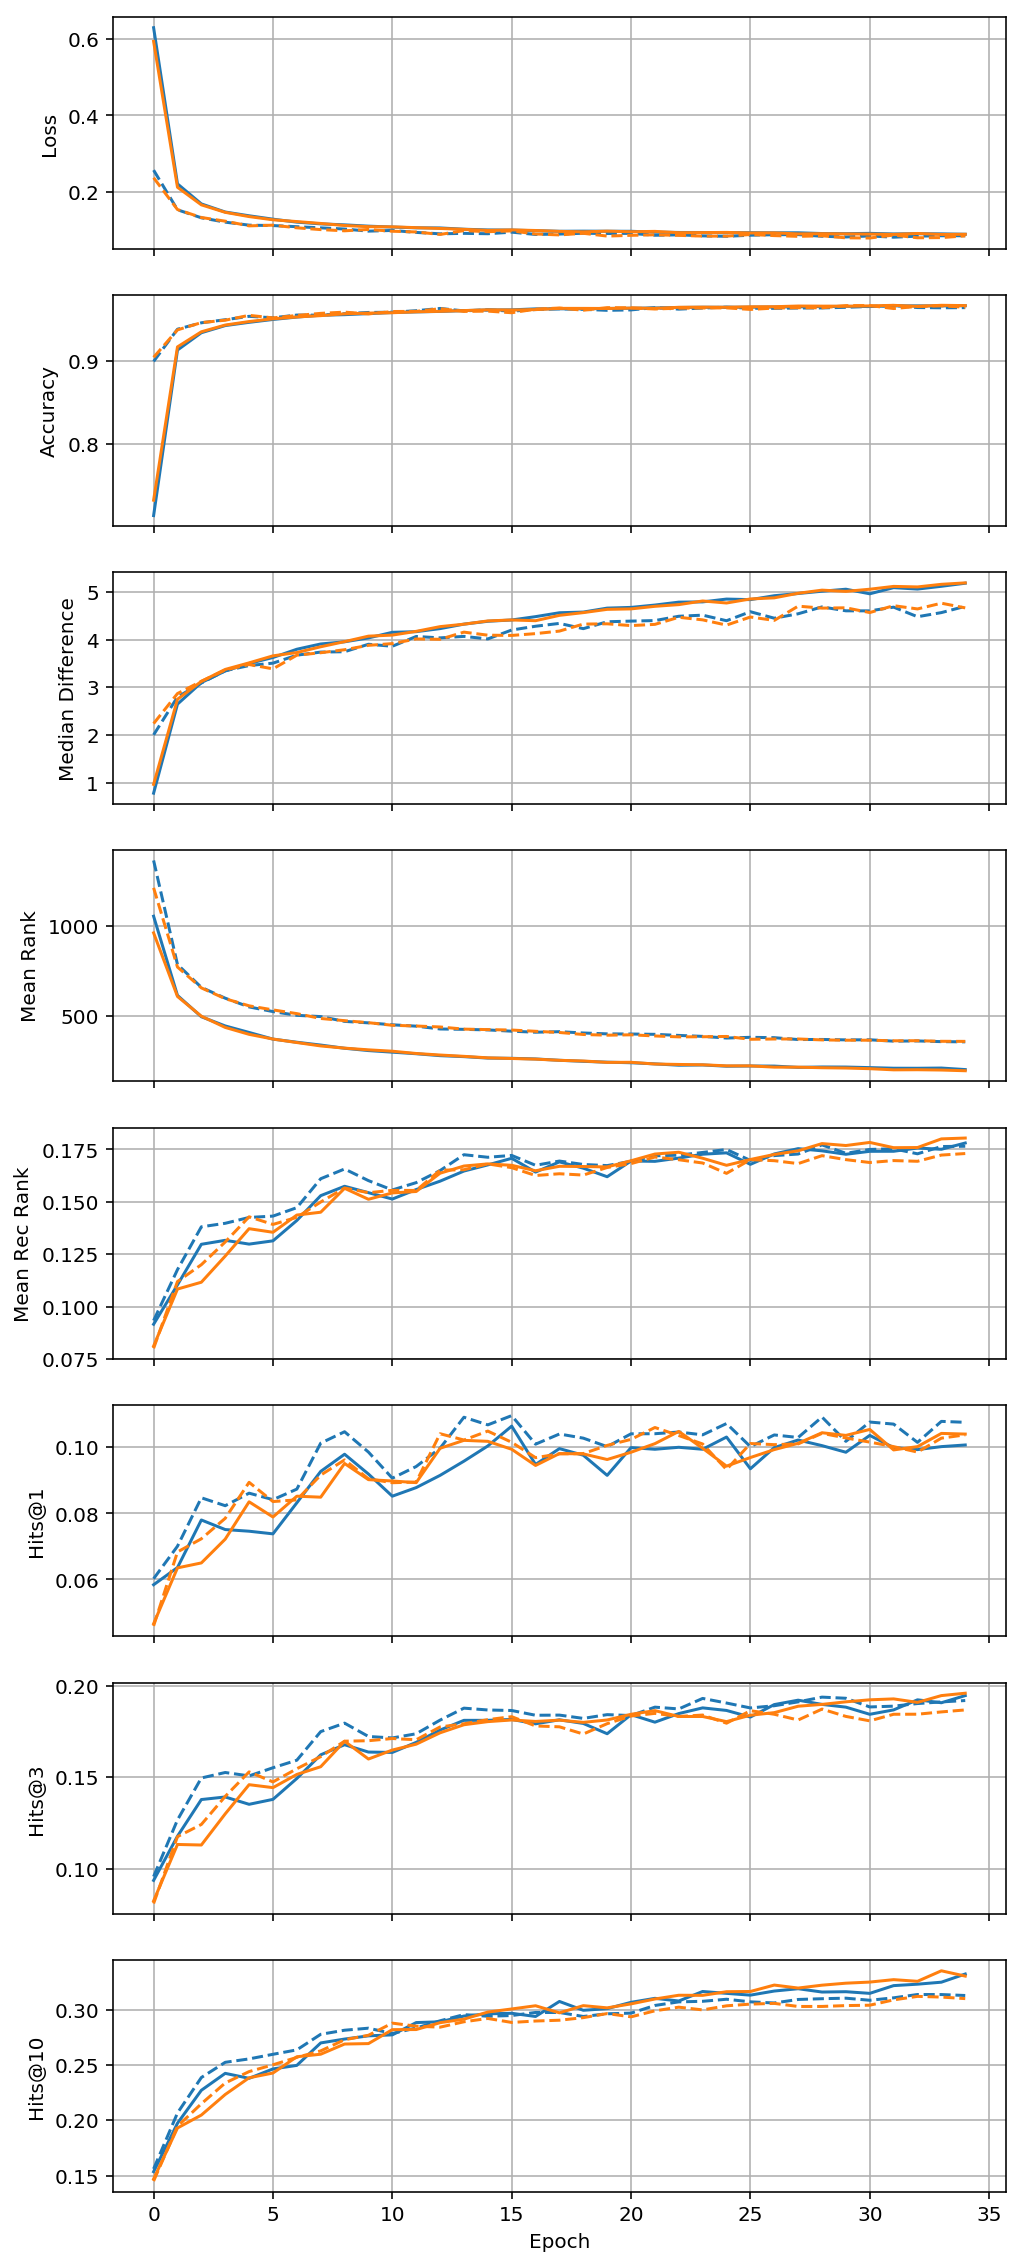

In [9]:
to_plot = ['loss', 'acc', 'median_diff', 'mean_rank', 'mean_rec_rank', 'hits_1', 'hits_3', 'hits_10']
figsize = (8, 20)

# TODO: Make fig legend for compare histories.
histories[0].plot(*to_plot, figsize=figsize, compare=histories[1:])#, xlim=(0, 10))

In [14]:
!ls logs

10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv
11_dist-mult.tsv
12_rgcn_new-one-hot-embedding_raw-ranking.tsv
13-0_filtered-ranking_same-parameters-with-different-seeds.tsv
13-1_filtered-ranking_same-parameters-with-different-seeds.tsv
13-2_filtered-ranking_same-parameters-with-different-seeds.tsv
13-3_filtered-ranking_same-parameters-with-different-seeds.tsv
13-4_filtered-ranking_same-parameters-with-different-seeds.tsv
13-5_filtered-ranking_same-parameters-with-different-seeds.tsv
13-6_filtered-ranking_same-parameters-with-different-seeds.tsv
14-0_only-weight-initialization-seeded.tsv
14-1_only-weight-initialization-seeded.tsv
14-2_only-weight-initialization-seeded.tsv
14-3_only-weight-initialization-seeded.tsv
15-0_only-training-loop-seeded.tsv
15-1_only-training-loop-seeded.tsv
15-2_only-training-loop-seeded.tsv
15-3_only-training-loop-seeded.tsv
16-0_DistMult-unseeded.tsv
16-1_DistMult-unseeded.tsv
16-2_DistMult-unseeded.tsv
16-3_DistMult-unseeded.tsv
17-0_

## Hyperparameter optimization

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
param_grid = {'a': [0, 1], 'b': [1, 2]}
num_runs = 5
force_cpu = False

for i_params, params in enumerate(ParameterGrid(param_grid)):
    # TODO: Store the parameters in History or somewhere else.

    for run in range(num_runs):
        base_name = 'logs/27-{}-{}_average-ranking_elu_lr0.001'.format(i_params+1, run+1)

        # TODO: Increase embedding_size to 500 like in original paper.
        net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200, 
                               dist_mult_dropout=0.5, activation=F.elu)
        embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
        if torch.cuda.is_available() and not force_cpu:
            net.cuda()
            #print('Moved network to GPU')
        optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
        # TODO: Increase batch_size and see if it changes results.
        batch_size = 64#32
        train_forward_kwargs = dict(num_sample=10)
        val_forward_kwargs = dict(num_sample=None)

        history = train_via_ranking(net, train_triples, val_triples, optimizer, num_nodes, train_ranker, val_ranker,
                                    embedding_func, scoring_func, num_epochs=35, batch_size=batch_size, margin=1, 
                                    train_forward_kwargs=train_forward_kwargs, val_forward_kwargs=val_forward_kwargs,
                                    save_best_to=base_name + '_best-model_state-dict.pt')

        # TODO: Save history to json.
        history.save(base_name + '_history.tsv')

In [ ]:
# TODO: Calculate averages of best validation scores, select parameter combination with best average.

## Evaluate on test set

In [10]:
test_ranker = RankingEvaluation(test_triples, num_nodes, filter_triples=all_triples if filtered else None, show_progress=True)

HBox(children=(IntProgress(value=0, max=20466), HTML(value=u'')))


Subject-corrupted triples: Found on average 435.1897293071436 triples that were actually true
Object-corrupted triples: Found on average 37.55184207954657 triples that were actually true


In [13]:
model_filenames = filter(lambda s: s.startswith('27') and s.endswith('.pt'), os.listdir('logs'))
print('Found', len(model_filenames), 'models')

val_metrics_per_model = []
test_metrics_per_model = []

for model_filename in model_filenames:
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200, dist_mult_dropout=0.5, activation=F.elu)
    net.load_state_dict(torch.load(os.path.join('logs', model_filename)))
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available():
        net.cuda()
        print('Moved network to GPU')
    val_forward_kwargs = dict(num_sample=None)
    
    net.eval()
    
    val_metrics = val_ranker(embedding_func, scoring_func, forward_kwargs=val_forward_kwargs)
    test_metrics = test_ranker(embedding_func, scoring_func, forward_kwargs=val_forward_kwargs)
    
    print(val_metrics)
    print(test_metrics)
    
    val_metrics_per_model.append(val_metrics)
    test_metrics_per_model.append(test_metrics)

Found 2 models
Initialized with OneHotEmbedding
Moved network to GPU
(355.6522241231822, 0.17305925075754902, 0.1037639007698888, 0.1866837753065298, 0.3099515255203878)
(361.8064717091762, 0.17160732699905862, 0.10317111306557217, 0.18545392358057267, 0.30548226326590444)
Initialized with OneHotEmbedding
Moved network to GPU
(366.4147134302823, 0.17718768066485707, 0.10915312232677502, 0.19366980325064156, 0.30986598232107215)
(375.2634857812958, 0.17428713227856613, 0.10490569725398222, 0.19131730675266295, 0.30812078569334506)


In [14]:
np.mean(val_metrics_per_model, axis=0)

array([3.61033469e+02, 1.75123466e-01, 1.06458512e-01, 1.90176789e-01,
       3.09908754e-01])

In [15]:
np.mean(test_metrics_per_model, axis=0)

array([3.68534979e+02, 1.72947230e-01, 1.04038405e-01, 1.88385615e-01,
       3.06801524e-01])

In [16]:
np.std(test_metrics_per_model, axis=0)# / np.sqrt(len(test_metrics_per_model))

array([6.72850704e+00, 1.33990264e-03, 8.67292094e-04, 2.93169159e-03,
       1.31926121e-03])

In [17]:
best_model = np.argmax(val_metrics_per_model, axis=0)[1]
test_metrics_per_model[best_model]

(375.2634857812958,
 0.17428713227856613,
 0.10490569725398222,
 0.19131730675266295,
 0.30812078569334506)

## Variation of results

In [23]:
# Everything seeded.

num_runs = 2
#histories = []

for i in range(num_runs):

    force_cpu = False
    history = utils.History()
    
    # Option 1: R-GCN
    seed_all(0)
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200)#200)
    #print(list(net.parameters())[0])
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available() and not force_cpu:
        net.cuda()
        print('Moved network to GPU')
    loss_function = SimplifiedMarginRankingLoss(1)
    optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    batch_size = 32
    num_sample_train = 10
    #num_sample_val = 10
    
    
    # Training loop. Run this again to continue training on the same network. 

    # TODO: Refactor to method train_model(net, num_epochs, embedding_func, scoring_func, loss_function, optimizer, batch_size, num_sample_train, num_sample_val, force_cpu=False)

    # TODO: Results seem to be very random (MRR after 1st epoch fluctuates between 0.25 and 0.35, 
    #       doesn't seem to converge after more epochs.) Try to make it more stable.
    #       Run it 5 times for 10 epochs and plot the results.
    
    num_epochs = 1
    #seed_all()

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # TODO: Implement training via classification of correct/corrupted triples like this:
        # num_negatives = 2
        # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
        # print(train_and_negatives.shape)
        # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
        # y[:len(train), 0] = 1
        # if torch.cuda.is_available() and not force_cpu:
        #     y = y.cuda()
        # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
        # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))

        # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
        batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)#[:2]
        batches = tqdm_notebook(batches)
        batches_history = utils.History()

        for batch, batch_triples in enumerate(batches):

            optimizer.zero_grad()
            output = net(batch_triples, num_sample=num_sample_train)
            output_negative = net(sample_negatives(batch_triples, num_nodes), num_sample=num_sample_train)

            loss = loss_function(output, output_negative)
            # loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

            # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
            batches_history.log_metric('loss', loss.data[0])
            batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
            batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
            batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

            if batch % 10 == 0:
                batches.set_postfix(batches_history.latest())

            # TODO: Check if this improves memory usage.
            del output, output_negative, loss


        net.eval()
        # TODO: Maybe sample over more/all nodes when testing. This should give better results. Make sure that the normalization is correct in this case!
        # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory.
        # TODO: Somehow, predict still takes up way to much gpu memory (around 5GB for val on fb15k-237; even though this is less than running the net directly on val, because this gives an OOM error). First, check that this is not just cached by doing torch.cuda.empty_cache() after every step. Then, check out that the variables are properly deleted.
        val_output = utils.predict(net, val_triples, batch_size=16, move_to_cpu=True)
        val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), batch_size=16, move_to_cpu=True)

        # TODO: Print num_sample from R-GCN layer and check if this works correctly.
        #val_output = utils.predict(net, val, forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
        #val_output_negative = utils.predict(net, sample_negatives(val, num_nodes), forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
        net.train()

        # TODO: Implement these metrics in a batched fashion.
        history.log_metric('loss', batches_history.mean('loss'), 
                           loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
        history.log_metric('acc', batches_history.mean('acc'), 
                           (val_output > val_output_negative).float().mean().data[0], 'Accuracy', print_=True)
        history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                           (val_output - val_output_negative).mean().data[0], 'Mean Difference', print_=True)
        history.log_metric('median_diff', batches_history.mean('median_diff'), 
                           (val_output - val_output_negative).median().data[0], 'Median Difference', print_=True)

        del val_output, val_output_negative

        print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
        mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func)
        print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
        val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func)
        history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
        history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
        history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
        history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
        history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

        print('-'*80)
        print()
        
    history.save('logs/17-{}_rgcn_everything-seeded.tsv'.format(i))


Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/1


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.653269511393
Val Loss:   0.542017519474

Accuracy:       0.64383382278
Val Accuracy:   0.645737111568

Mean Difference:       0.918142875768
Val Mean Difference:   1.40951931477

Median Difference:       0.369668644572
Val Median Difference:   0.655971825123

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1388.0861
Val Mean Rank:   1475.64009125

Mean Rec Rank:       0.262485832099
Val Mean Rec Rank:   0.324063090505

Hits@1:       0.2387
Val Hits@1:   0.299372683205

Hits@3:       0.2641
Val Hits@3:   0.327858568577

Hits@10:       0.3072
Val Hits@10:   0.371371542629

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/1


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.653269511393
Val Loss:   0.542017519474

Accuracy:       0.64383382278
Val Accuracy:   0.645737111568

Mean Difference:       0.918142875768
Val Mean Difference:   1.40951931477

Median Difference:       0.369668644572
Val Median Difference:   0.655971825123

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1388.0861
Val Mean Rank:   1475.64009125

Mean Rec Rank:       0.262485832099
Val Mean Rec Rank:   0.324063090505

Hits@1:       0.2387
Val Hits@1:   0.299372683205

Hits@3:       0.2641
Val Hits@3:   0.327858568577

Hits@10:       0.3072
Val Hits@10:   0.371371542629

--------------------------------------------------------------------------------



In [19]:
# Only training loop seeded.

num_runs = 3
#histories = []

for i in range(num_runs):

    force_cpu = False
    history = utils.History()
    
    # Option 1: R-GCN
    seed_all()
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200)
    print(list(net.parameters())[0])
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available() and not force_cpu:
        net.cuda()
        print('Moved network to GPU')
    loss_function = SimplifiedMarginRankingLoss(1)
    optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    batch_size = 32
    num_sample_train = 10
    num_sample_val = 10
    
    
    # Training loop. Run this again to continue training on the same network. 

    # TODO: Refactor to method train_model(net, num_epochs, embedding_func, scoring_func, loss_function, optimizer, batch_size, num_sample_train, num_sample_val, force_cpu=False)

    # TODO: Results seem to be very random (MRR after 1st epoch fluctuates between 0.25 and 0.35, 
    #       doesn't seem to converge after more epochs.) Try to make it more stable.
    #       Run it 5 times for 10 epochs and plot the results.
    
    num_epochs = 1
    seed_all(0)

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # TODO: Implement training via classification of correct/corrupted triples like this:
        # num_negatives = 2
        # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
        # print(train_and_negatives.shape)
        # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
        # y[:len(train), 0] = 1
        # if torch.cuda.is_available() and not force_cpu:
        #     y = y.cuda()
        # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
        # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))

        # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
        batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)[:2]
        batches = tqdm_notebook(batches)
        batches_history = utils.History()

        for batch, batch_triples in enumerate(batches):

            optimizer.zero_grad()
            print('getting output')
            output = net(batch_triples, num_sample=num_sample_train)
            print('getting negative output')
            output_negative = net(sample_negatives(batch_triples, num_nodes), num_sample=num_sample_train)

            loss = loss_function(output, output_negative)
            # loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

            # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
            batches_history.log_metric('loss', loss.data[0])
            batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
            batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
            batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

            if batch % 10 == 0:
                batches.set_postfix(batches_history.latest())

            # TODO: Check if this improves memory usage.
            del output, output_negative, loss
            print()


#         net.eval()
#         # TODO: Maybe sample over more/all nodes when testing. This should give better results. Make sure that the normalization is correct in this case!
#         # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory.
#         # TODO: Somehow, predict still takes up way to much gpu memory (around 5GB for val on fb15k-237; even though this is less than running the net directly on val, because this gives an OOM error). First, check that this is not just cached by doing torch.cuda.empty_cache() after every step. Then, check out that the variables are properly deleted.
#         val_output = utils.predict(net, val_triples, batch_size=16, move_to_cpu=True)
#         val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), batch_size=16, move_to_cpu=True)

#         # TODO: Print num_sample from R-GCN layer and check if this works correctly.
#         #val_output = utils.predict(net, val, forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
#         #val_output_negative = utils.predict(net, sample_negatives(val, num_nodes), forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
#         net.train()

#         # TODO: Implement these metrics in a batched fashion.
#         history.log_metric('loss', batches_history.mean('loss'), 
#                            loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
#         history.log_metric('acc', batches_history.mean('acc'), 
#                            (val_output > val_output_negative).float().mean().data[0], 'Accuracy', print_=True)
#         history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
#                            (val_output - val_output_negative).mean().data[0], 'Mean Difference', print_=True)
#         history.log_metric('median_diff', batches_history.mean('median_diff'), 
#                            (val_output - val_output_negative).median().data[0], 'Median Difference', print_=True)

#         del val_output, val_output_negative

        print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
        mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func)
#         print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
#         val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func)
#         history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
#         history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
#         history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
#         history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
#         history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

        print('-'*80)
        print()
        
    #history.save('logs/15-{}_only-training-loop-seeded.tsv'.format(i))


Initialized with OneHotEmbedding
Parameter containing:
-8.6023e-04 -3.2349e-03  1.8845e-02  ...   5.1325e-03  2.4720e-03 -1.6137e-02
 1.2604e-02 -1.4042e-02 -1.7100e-02  ...  -1.9248e-02  3.3568e-03 -4.0528e-03
-3.2101e-03  3.9390e-04  1.3783e-02  ...  -1.3662e-02  2.9955e-03  1.7676e-02
                ...                   ⋱                   ...                
 4.6084e-03 -4.7167e-03  1.2678e-02  ...   1.9633e-02 -4.1882e-03  1.8469e-02
-8.9499e-03 -1.3343e-02 -8.7699e-03  ...   1.7916e-02  1.1680e-02  1.0923e-02
-4.5542e-03 -1.3701e-02 -1.3590e-02  ...  -6.6108e-03 -1.9965e-02  1.3296e-02
[torch.FloatTensor of size 200x14541]

Moved network to GPU
Epoch 1/1


HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

getting output
conv2 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 set([1921, 9801, 11777, 11977, 10634, 6763, 10894, 534, 4087, 441])
conv2 set([11777, 11912, 11977, 10894, 723, 14260, 10683, 3389, 4158, 4351])
conv1 : Call to forward with 278 nodes: [ 4096 11777  4100  8197  3590]
conv1 set([288, 706, 2251, 1546, 11979, 5282, 14517, 3746, 2204, 5373])
conv2 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 set([9089, 3426, 743, 3916, 3569, 5617, 888, 2424, 9595, 8991])
conv2 set([2662, 6955, 6541, 5617, 9589, 534, 535, 888, 441, 5692])
conv1 : Call to forward with 215 nodes: [ 7680  5635  9226   523 11277]
conv1 set([4833, 10058, 5181, 8495, 10416, 5458, 11700, 5629, 702, 9535])
getting negative output
conv2 : Call to forward with 32 nodes: [  619 11217 11821  7967  8049]
conv1 : Call to forward wit

HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

getting output
conv2 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 set([1921, 9801, 11777, 11977, 10634, 6763, 10894, 534, 4087, 441])
conv2 set([11777, 11912, 11977, 10894, 723, 14260, 10683, 3389, 4158, 4351])
conv1 : Call to forward with 278 nodes: [ 4096 11777  4100  8197  3590]
conv1 set([288, 706, 2251, 1546, 11979, 5282, 14517, 3746, 2204, 5373])
conv2 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 set([9089, 3426, 743, 3916, 3569, 5617, 888, 2424, 9595, 8991])
conv2 set([2662, 6955, 6541, 5617, 9589, 534, 535, 888, 441, 5692])
conv1 : Call to forward with 215 nodes: [ 7680  5635  9226   523 11277]
conv1 set([4833, 10058, 5181, 8495, 10416, 5458, 11700, 5629, 702, 9535])
getting negative output
conv2 : Call to forward with 32 nodes: [  619 11217 11821  7967  8049]
conv1 : Call to forward wit

HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

getting output
conv2 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 set([1921, 9801, 11777, 11977, 10634, 6763, 10894, 534, 4087, 441])
conv2 set([11777, 11912, 11977, 10894, 723, 14260, 10683, 3389, 4158, 4351])
conv1 : Call to forward with 278 nodes: [ 4096 11777  4100  8197  3590]
conv1 set([288, 706, 2251, 1546, 11979, 5282, 14517, 3746, 2204, 5373])
conv2 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 set([9089, 3426, 743, 3916, 3569, 5617, 888, 2424, 9595, 8991])
conv2 set([2662, 6955, 6541, 5617, 9589, 534, 535, 888, 441, 5692])
conv1 : Call to forward with 215 nodes: [ 7680  5635  9226   523 11277]
conv1 set([4833, 10058, 5181, 8495, 10416, 5458, 11700, 5629, 702, 9535])
getting negative output
conv2 : Call to forward with 32 nodes: [  619 11217 11821  7967  8049]
conv1 : Call to forward wit

In [20]:
# Nothing seeded, with dist mult dropout.

num_runs = 4
#histories = []

for i in range(num_runs):

    force_cpu = False
    history = utils.History()
    
    # Option 1: R-GCN
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200, dist_mult_dropout=0.4)
    #print(list(net.parameters())[0])
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available() and not force_cpu:
        net.cuda()
        print('Moved network to GPU')
    loss_function = SimplifiedMarginRankingLoss(1)
    optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    batch_size = 32
    num_sample_train = 10
    num_sample_val = 10
    
    
    # Training loop. Run this again to continue training on the same network. 

    # TODO: Refactor to method train_model(net, num_epochs, embedding_func, scoring_func, loss_function, optimizer, batch_size, num_sample_train, num_sample_val, force_cpu=False)

    # TODO: Results seem to be very random (MRR after 1st epoch fluctuates between 0.25 and 0.35, 
    #       doesn't seem to converge after more epochs.) Try to make it more stable.
    #       Run it 5 times for 10 epochs and plot the results.
    
    num_epochs = 10

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # TODO: Implement training via classification of correct/corrupted triples like this:
        # num_negatives = 2
        # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
        # print(train_and_negatives.shape)
        # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
        # y[:len(train), 0] = 1
        # if torch.cuda.is_available() and not force_cpu:
        #     y = y.cuda()
        # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
        # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))

        # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
        batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)#[:2]
        batches = tqdm_notebook(batches)
        batches_history = utils.History()

        for batch, batch_triples in enumerate(batches):

            optimizer.zero_grad()
            #print('getting output')
            output = net(batch_triples, num_sample=num_sample_train)
            #print('getting negative output')
            output_negative = net(sample_negatives(batch_triples, num_nodes), num_sample=num_sample_train)

            loss = loss_function(output, output_negative)
            # loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

            # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
            batches_history.log_metric('loss', loss.data[0])
            batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
            batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
            batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

            if batch % 10 == 0:
                batches.set_postfix(batches_history.latest())

            # TODO: Check if this improves memory usage.
            del output, output_negative, loss
            #print()


        net.eval()
#         # TODO: Maybe sample over more/all nodes when testing. This should give better results. Make sure that the normalization is correct in this case!
#         # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory.
#         # TODO: Somehow, predict still takes up way to much gpu memory (around 5GB for val on fb15k-237; even though this is less than running the net directly on val, because this gives an OOM error). First, check that this is not just cached by doing torch.cuda.empty_cache() after every step. Then, check out that the variables are properly deleted.
        val_output = utils.predict(net, val_triples, batch_size=16, move_to_cpu=True)
        val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), batch_size=16, move_to_cpu=True)

#         # TODO: Print num_sample from R-GCN layer and check if this works correctly.
#         #val_output = utils.predict(net, val, forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
#         #val_output_negative = utils.predict(net, sample_negatives(val, num_nodes), forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
        net.train()

#         # TODO: Implement these metrics in a batched fashion.
        history.log_metric('loss', batches_history.mean('loss'), 
                           loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
        history.log_metric('acc', batches_history.mean('acc'), 
                           (val_output > val_output_negative).float().mean().data[0], 'Accuracy', print_=True)
        history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                           (val_output - val_output_negative).mean().data[0], 'Mean Difference', print_=True)
        history.log_metric('median_diff', batches_history.mean('median_diff'), 
                           (val_output - val_output_negative).median().data[0], 'Median Difference', print_=True)

        del val_output, val_output_negative

        print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
        mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func)
        print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
        val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func)
        history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
        history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
        history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
        history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
        history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

        print('-'*80)
        print()
        
    #histories.append(history)
    history.save('logs/18-{}_nothing-seeded_rgcn-with-dist-mult-dropout.tsv'.format(i))


Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.716309885893
Val Loss:   0.592484474182

Accuracy:       0.654827681711
Val Accuracy:   0.66678071022

Mean Difference:       0.679676658178
Val Mean Difference:   1.00714814663

Median Difference:       0.248109197539
Val Median Difference:   0.492503643036

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       2104.7974
Val Mean Rank:   2201.06102082

Mean Rec Rank:       0.233185772617
Val Mean Rec Rank:   0.258173207816

Hits@1:       0.2159
Val Hits@1:   0.236641003707

Hits@3:       0.2362
Val Hits@3:   0.264043341888

Hits@10:       0.2617
Val Hits@10:   0.293185058455

--------------------------------------------------------------------------------

Epoch 2/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.53432151609
Val Loss:   0.480867773294

Accuracy:       0.694866115636
Val Accuracy:   0.706472754478

Mean Difference:       1.26067362984
Val Mean Difference:   1.34102928638

Median Difference:       0.750101267135
Val Median Difference:   0.973938107491

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1463.1609
Val Mean Rank:   1560.14069005

Mean Rec Rank:       0.25460385085
Val Mean Rec Rank:   0.282194917973

Hits@1:       0.2337
Val Hits@1:   0.257570573139

Hits@3:       0.2561
Val Hits@3:   0.285942400912

Hits@10:       0.2951
Val Hits@10:   0.328942115768

--------------------------------------------------------------------------------

Epoch 3/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.455795923369
Val Loss:   0.416573137045

Accuracy:       0.719743340598
Val Accuracy:   0.72517824173

Mean Difference:       1.61800628393
Val Mean Difference:   1.70281708241

Median Difference:       1.13035928353
Val Median Difference:   1.34383368492

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1137.2584
Val Mean Rank:   1242.23627032

Mean Rec Rank:       0.254843000885
Val Mean Rec Rank:   0.280552815256

Hits@1:       0.2304
Val Hits@1:   0.251611063587

Hits@3:       0.2578
Val Hits@3:   0.285400627317

Hits@10:       0.2967
Val Hits@10:   0.332306814942

--------------------------------------------------------------------------------

Epoch 4/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.411005033294
Val Loss:   0.37900981307

Accuracy:       0.73519659479
Val Accuracy:   0.739549458027

Mean Difference:       1.90541736093
Val Mean Difference:   2.04527854919

Median Difference:       1.41105847993
Val Median Difference:   1.65210080147

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       969.1936
Val Mean Rank:   1074.16022241

Mean Rec Rank:       0.255356894998
Val Mean Rec Rank:   0.278096159534

Hits@1:       0.2292
Val Hits@1:   0.24627887083

Hits@3:       0.2552
Val Hits@3:   0.282007413744

Hits@10:       0.3045
Val Hits@10:   0.338237810094

--------------------------------------------------------------------------------

Epoch 5/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.385125338538
Val Loss:   0.363905638456

Accuracy:       0.744058910361
Val Accuracy:   0.742058753967

Mean Difference:       2.13486889142
Val Mean Difference:   2.22232961655

Median Difference:       1.6156409609
Val Median Difference:   1.78000807762

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       874.8294
Val Mean Rank:   975.522897063

Mean Rec Rank:       0.255153913971
Val Mean Rec Rank:   0.281362505552

Hits@1:       0.2271
Val Hits@1:   0.246849158825

Hits@3:       0.254
Val Hits@3:   0.285913886513

Hits@10:       0.3092
Val Hits@10:   0.348018249216

--------------------------------------------------------------------------------

Epoch 6/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.367806678831
Val Loss:   0.352448910475

Accuracy:       0.749869836794
Val Accuracy:   0.747419476509

Mean Difference:       2.32799351501
Val Mean Difference:   2.4325158596

Median Difference:       1.75260508598
Val Median Difference:   1.93859398365

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       804.6702
Val Mean Rank:   904.920102652

Mean Rec Rank:       0.258218268697
Val Mean Rec Rank:   0.282057882045

Hits@1:       0.2287
Val Hits@1:   0.247704590818

Hits@3:       0.2594
Val Hits@3:   0.285457656116

Hits@10:       0.3111
Val Hits@10:   0.346564014827

--------------------------------------------------------------------------------

Epoch 7/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.358834573067
Val Loss:   0.351604342461

Accuracy:       0.752173899588
Val Accuracy:   0.744111776352

Mean Difference:       2.48514984533
Val Mean Difference:   2.5264351368

Median Difference:       1.85413086675
Val Median Difference:   1.99118852615

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       759.9542
Val Mean Rank:   864.295694326

Mean Rec Rank:       0.258364749797
Val Mean Rec Rank:   0.283131612671

Hits@1:       0.2277
Val Hits@1:   0.250213857998

Hits@3:       0.2605
Val Hits@3:   0.285229540918

Hits@10:       0.3134
Val Hits@10:   0.342971200456

--------------------------------------------------------------------------------

Epoch 8/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.351483848242
Val Loss:   0.342184513807

Accuracy:       0.755129745446
Val Accuracy:   0.749130308628

Mean Difference:       2.59810619993
Val Mean Difference:   2.66928124428

Median Difference:       1.91217374309
Val Median Difference:   2.07200360298

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       728.1139
Val Mean Rank:   829.291531223

Mean Rec Rank:       0.261113682744
Val Mean Rec Rank:   0.283518995338

Hits@1:       0.2284
Val Hits@1:   0.247191331622

Hits@3:       0.2635
Val Hits@3:   0.286598232107

Hits@10:       0.3228
Val Hits@10:   0.354205873966

--------------------------------------------------------------------------------

Epoch 9/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.343657146785
Val Loss:   0.337593495846

Accuracy:       0.758452872026
Val Accuracy:   0.749415457249

Mean Difference:       2.74141415098
Val Mean Difference:   2.81655097008

Median Difference:       1.98862362327
Val Median Difference:   2.14875745773

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       698.2926
Val Mean Rank:   805.768833761

Mean Rec Rank:       0.265116169249
Val Mean Rec Rank:   0.290015244844

Hits@1:       0.2325
Val Hits@1:   0.254006273168

Hits@3:       0.2669
Val Hits@3:   0.29369831765

Hits@10:       0.3272
Val Hits@10:   0.360307955518

--------------------------------------------------------------------------------

Epoch 10/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.341188535447
Val Loss:   0.330618351698

Accuracy:       0.759333842897
Val Accuracy:   0.754148840904

Mean Difference:       2.83625938412
Val Mean Difference:   2.87172794342

Median Difference:       2.03590908113
Val Median Difference:   2.12620949745

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       673.516
Val Mean Rank:   781.283404619

Mean Rec Rank:       0.258449556644
Val Mean Rec Rank:   0.281159606723

Hits@1:       0.2257
Val Hits@1:   0.244311377246

Hits@3:       0.2595
Val Hits@3:   0.283347590533

Hits@10:       0.3196
Val Hits@10:   0.352780153978

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.699244066106
Val Loss:   0.594800412655

Accuracy:       0.665984196292
Val Accuracy:   0.675392091274

Mean Difference:       0.719581694608
Val Mean Difference:   0.905579209328

Median Difference:       0.289927084953
Val Median Difference:   0.457513153553

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       2050.0824
Val Mean Rank:   2269.32007414

Mean Rec Rank:       0.216327156097
Val Mean Rec Rank:   0.244359247131

Hits@1:       0.1948
Val Hits@1:   0.220273738238

Hits@3:       0.2172
Val Hits@3:   0.247790134018

Hits@10:       0.259
Val Hits@10:   0.291502708868

--------------------------------------------------------------------------------

Epoch 2/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.508878963282
Val Loss:   0.476732760668

Accuracy:       0.707939878141
Val Accuracy:   0.704419732094

Mean Difference:       1.38771082401
Val Mean Difference:   1.37383115292

Median Difference:       0.859355359107
Val Median Difference:   0.987739741802

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1423.206
Val Mean Rank:   1588.05126889

Mean Rec Rank:       0.231102716045
Val Mean Rec Rank:   0.266540837929

Hits@1:       0.2053
Val Hits@1:   0.239692044482

Hits@3:       0.2332
Val Hits@3:   0.270487596236

Hits@10:       0.2771
Val Hits@10:   0.316481323068

--------------------------------------------------------------------------------

Epoch 3/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.432658539496
Val Loss:   0.418181955814

Accuracy:       0.730988822597
Val Accuracy:   0.722783029079

Mean Difference:       1.81118240161
Val Mean Difference:   1.72616040707

Median Difference:       1.27699563755
Val Median Difference:   1.36843860149

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1082.6492
Val Mean Rank:   1249.12135729

Mean Rec Rank:       0.233613722955
Val Mean Rec Rank:   0.26512270037

Hits@1:       0.2048
Val Hits@1:   0.233846592529

Hits@3:       0.2358
Val Hits@3:   0.270772740234

Hits@10:       0.2876
Val Hits@10:   0.322241231822

--------------------------------------------------------------------------------

Epoch 4/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.392913160859
Val Loss:   0.383206248283

Accuracy:       0.744080958809
Val Accuracy:   0.734416902065

Mean Difference:       2.10741056281
Val Mean Difference:   2.01020526886

Median Difference:       1.55318344601
Val Median Difference:   1.61907553673

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       896.095
Val Mean Rank:   1057.25163958

Mean Rec Rank:       0.23661000187
Val Mean Rec Rank:   0.268798812614

Hits@1:       0.2084
Val Hits@1:   0.237952666096

Hits@3:       0.2371
Val Hits@3:   0.27125748503

Hits@10:       0.2912
Val Hits@10:   0.328628457371

--------------------------------------------------------------------------------

Epoch 5/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.367255411768
Val Loss:   0.361722648144

Accuracy:       0.753396234586
Val Accuracy:   0.742514967918

Mean Difference:       2.32998529526
Val Mean Difference:   2.2334382534

Median Difference:       1.74728376167
Val Median Difference:   1.80271565914

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       815.8835
Val Mean Rank:   968.675135443

Mean Rec Rank:       0.236064600279
Val Mean Rec Rank:   0.26611445688

Hits@1:       0.2037
Val Hits@1:   0.230225263758

Hits@3:       0.238
Val Hits@3:   0.273282007414

Hits@10:       0.2968
Val Hits@10:   0.331850584545

--------------------------------------------------------------------------------

Epoch 6/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.352528614566
Val Loss:   0.352316081524

Accuracy:       0.758984549067
Val Accuracy:   0.745537519455

Mean Difference:       2.52692617291
Val Mean Difference:   2.46258091927

Median Difference:       1.88692202473
Val Median Difference:   1.92731904984

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       747.0185
Val Mean Rank:   899.327031651

Mean Rec Rank:       0.238637988282
Val Mean Rec Rank:   0.268588366935

Hits@1:       0.2064
Val Hits@1:   0.23373253493

Hits@3:       0.238
Val Hits@3:   0.272084402623

Hits@10:       0.3033
Val Hits@10:   0.333989164528

--------------------------------------------------------------------------------

Epoch 7/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.342102618062
Val Loss:   0.349452853203

Accuracy:       0.763060997614
Val Accuracy:   0.744853138924

Mean Difference:       2.71329303014
Val Mean Difference:   2.58188056946

Median Difference:       2.00753072141
Val Median Difference:   2.00552845001

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       708.7285
Val Mean Rank:   857.432706017

Mean Rec Rank:       0.238649124608
Val Mean Rec Rank:   0.268795307652

Hits@1:       0.2041
Val Hits@1:   0.231422868549

Hits@3:       0.2401
Val Hits@3:   0.273167949815

Hits@10:       0.305
Val Hits@10:   0.34251497006

--------------------------------------------------------------------------------

Epoch 8/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.334584938005
Val Loss:   0.334136009216

Accuracy:       0.765269323721
Val Accuracy:   0.752038776875

Mean Difference:       2.85601168279
Val Mean Difference:   2.79410505295

Median Difference:       2.07726056341
Val Median Difference:   2.12166190147

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       676.0229
Val Mean Rank:   824.315711434

Mean Rec Rank:       0.241441930809
Val Mean Rec Rank:   0.269984487026

Hits@1:       0.2069
Val Hits@1:   0.23253493014

Hits@3:       0.2439
Val Hits@3:   0.276532648988

Hits@10:       0.3072
Val Hits@10:   0.340604505275

--------------------------------------------------------------------------------

Epoch 9/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.329870768095
Val Loss:   0.332531780005

Accuracy:       0.765901572638
Val Accuracy:   0.751468479633

Mean Difference:       2.96961253134
Val Mean Difference:   2.83442950249

Median Difference:       2.14396422041
Val Median Difference:   2.13615179062

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       640.9181
Val Mean Rank:   795.499344169

Mean Rec Rank:       0.240564121082
Val Mean Rec Rank:   0.26924237534

Hits@1:       0.2035
Val Hits@1:   0.228828058169

Hits@3:       0.2481
Val Hits@3:   0.276504134588

Hits@10:       0.3043
Val Hits@10:   0.343826632449

--------------------------------------------------------------------------------

Epoch 10/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.322919192788
Val Loss:   0.333127498627

Accuracy:       0.769596041489
Val Accuracy:   0.752494990826

Mean Difference:       3.11668328341
Val Mean Difference:   2.99149179459

Median Difference:       2.22676847212
Val Median Difference:   2.21312689781

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       625.134
Val Mean Rank:   779.409609353

Mean Rec Rank:       0.239871745776
Val Mean Rec Rank:   0.266251949417

Hits@1:       0.2031
Val Hits@1:   0.225948103792

Hits@3:       0.2429
Val Hits@3:   0.272084402623

Hits@10:       0.3092
Val Hits@10:   0.342429426861

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.696197348991
Val Loss:   0.596444547176

Accuracy:       0.664150306978
Val Accuracy:   0.661933302879

Mean Difference:       0.776953646615
Val Mean Difference:   1.05524027348

Median Difference:       0.301601378225
Val Median Difference:   0.49837872386

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1969.7287
Val Mean Rank:   2070.05278015

Mean Rec Rank:       0.232068969631
Val Mean Rec Rank:   0.301739646649

Hits@1:       0.2107
Val Hits@1:   0.278443113772

Hits@3:       0.2347
Val Hits@3:   0.307242657542

Hits@10:       0.2711
Val Hits@10:   0.34502423724

--------------------------------------------------------------------------------

Epoch 2/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.50211027661
Val Loss:   0.488345593214

Accuracy:       0.71164517781
Val Accuracy:   0.688736796379

Mean Difference:       1.48615023622
Val Mean Difference:   1.51539433002

Median Difference:       0.893956963007
Val Median Difference:   0.974370718002

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1326.326
Val Mean Rank:   1464.6609923

Mean Rec Rank:       0.238134242065
Val Mean Rec Rank:   0.300791109671

Hits@1:       0.2121
Val Hits@1:   0.271457085828

Hits@3:       0.2407
Val Hits@3:   0.307071571143

Hits@10:       0.2825
Val Hits@10:   0.352095808383

--------------------------------------------------------------------------------

Epoch 3/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.429104168685
Val Loss:   0.435350358486

Accuracy:       0.734914993564
Val Accuracy:   0.706073582172

Mean Difference:       1.94366836673
Val Mean Difference:   1.90138185024

Median Difference:       1.30369650434
Val Median Difference:   1.31195616722

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1037.1377
Val Mean Rank:   1146.20290847

Mean Rec Rank:       0.238240017665
Val Mean Rec Rank:   0.305264781273

Hits@1:       0.211
Val Hits@1:   0.276390076989

Hits@3:       0.2398
Val Hits@3:   0.311405759909

Hits@10:       0.2848
Val Hits@10:   0.351183347591

--------------------------------------------------------------------------------

Epoch 4/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.386333491141
Val Loss:   0.393473178148

Accuracy:       0.750318155232
Val Accuracy:   0.723980605602

Mean Difference:       2.28005875107
Val Mean Difference:   2.21802687645

Median Difference:       1.60327007599
Val Median Difference:   1.59820997715

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       877.6098
Val Mean Rank:   986.415084117

Mean Rec Rank:       0.245253251347
Val Mean Rec Rank:   0.308603773015

Hits@1:       0.215
Val Hits@1:   0.277131451383

Hits@3:       0.2473
Val Hits@3:   0.312318220701

Hits@10:       0.3047
Val Hits@10:   0.368976333048

--------------------------------------------------------------------------------

Epoch 5/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.363508780884
Val Loss:   0.377778202295

Accuracy:       0.758424827943
Val Accuracy:   0.72956943512

Mean Difference:       2.50777594842
Val Mean Difference:   2.44663667679

Median Difference:       1.77282675704
Val Median Difference:   1.78607583046

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       790.3203
Val Mean Rank:   883.74704876

Mean Rec Rank:       0.247966759522
Val Mean Rec Rank:   0.313521689383

Hits@1:       0.2174
Val Hits@1:   0.283147989735

Hits@3:       0.2502
Val Hits@3:   0.316139150271

Hits@10:       0.3052
Val Hits@10:   0.36994582264

--------------------------------------------------------------------------------

Epoch 6/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.346716652169
Val Loss:   0.362734228373

Accuracy:       0.764300545872
Val Accuracy:   0.730995178223

Mean Difference:       2.74477863778
Val Mean Difference:   2.65902400017

Median Difference:       1.91960150173
Val Median Difference:   1.87164950371

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       726.732
Val Mean Rank:   832.499828914

Mean Rec Rank:       0.253891319561
Val Mean Rec Rank:   0.320616529738

Hits@1:       0.2216
Val Hits@1:   0.289250071286

Hits@3:       0.2586
Val Hits@3:   0.322897063017

Hits@10:       0.3106
Val Hits@10:   0.38123752495

--------------------------------------------------------------------------------

Epoch 7/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.337211084224
Val Loss:   0.358372718096

Accuracy:       0.767902952791
Val Accuracy:   0.734473884106

Mean Difference:       2.91420080417
Val Mean Difference:   2.83982419968

Median Difference:       2.01957239113
Val Median Difference:   1.9505302906

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       677.8954
Val Mean Rank:   781.382235529

Mean Rec Rank:       0.251141271169
Val Mean Rec Rank:   0.311433273933

Hits@1:       0.2182
Val Hits@1:   0.27747362418

Hits@3:       0.2524
Val Hits@3:   0.315340747077

Hits@10:       0.3117
Val Hits@10:   0.374565155403

--------------------------------------------------------------------------------

Epoch 8/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.330408458603
Val Loss:   0.349296689034

Accuracy:       0.770002583927
Val Accuracy:   0.73646992445

Mean Difference:       3.03874882234
Val Mean Difference:   2.93662881851

Median Difference:       2.07791637223
Val Median Difference:   2.04880547523

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       639.2615
Val Mean Rank:   744.044140291

Mean Rec Rank:       0.252897320923
Val Mean Rec Rank:   0.313683134007

Hits@1:       0.2207
Val Hits@1:   0.281608212147

Hits@3:       0.2545
Val Hits@3:   0.315854006273

Hits@10:       0.3104
Val Hits@10:   0.372569147419

--------------------------------------------------------------------------------

Epoch 9/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.325203655594
Val Loss:   0.340213388205

Accuracy:       0.770975229923
Val Accuracy:   0.740176796913

Mean Difference:       3.17443313582
Val Mean Difference:   3.17222213745

Median Difference:       2.17034947612
Val Median Difference:   2.16793084145

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       610.8363
Val Mean Rank:   723.180524665

Mean Rec Rank:       0.251053426792
Val Mean Rec Rank:   0.314289097374

Hits@1:       0.2151
Val Hits@1:   0.277701739378

Hits@3:       0.2572
Val Hits@3:   0.321414314229

Hits@10:       0.3104
Val Hits@10:   0.378557171372

--------------------------------------------------------------------------------

Epoch 10/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.318708568863
Val Loss:   0.338445931673

Accuracy:       0.774614577663
Val Accuracy:   0.74114626646

Mean Difference:       3.26914383498
Val Mean Difference:   3.19535160065

Median Difference:       2.22799485609
Val Median Difference:   2.17095899582

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       590.9826
Val Mean Rank:   705.642743085

Mean Rec Rank:       0.254262383875
Val Mean Rec Rank:   0.315889561371

Hits@1:       0.2183
Val Hits@1:   0.279868833761

Hits@3:       0.2585
Val Hits@3:   0.322355289421

Hits@10:       0.3169
Val Hits@10:   0.375506130596

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.709278783907
Val Loss:   0.61063426733

Accuracy:       0.642524454438
Val Accuracy:   0.632335305214

Mean Difference:       0.851399810873
Val Mean Difference:   1.27497291565

Median Difference:       0.250822432405
Val Median Difference:   0.346237778664

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1904.9529
Val Mean Rank:   2054.77815797

Mean Rec Rank:       0.33123102759
Val Mean Rec Rank:   0.38916178798

Hits@1:       0.3109
Val Hits@1:   0.370772740234

Hits@3:       0.3394
Val Hits@3:   0.396179070431

Hits@10:       0.3638
Val Hits@10:   0.419931565441

--------------------------------------------------------------------------------

Epoch 2/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.519856439516
Val Loss:   0.512744128704

Accuracy:       0.68868906892
Val Accuracy:   0.661477029324

Mean Difference:       1.80741493169
Val Mean Difference:   1.9012928009

Median Difference:       0.799192242664
Val Median Difference:   0.791016221046

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1317.5732
Val Mean Rank:   1470.37619048

Mean Rec Rank:       0.341164483754
Val Mean Rec Rank:   0.400151471897

Hits@1:       0.318
Val Hits@1:   0.376504134588

Hits@3:       0.3486
Val Hits@3:   0.409010550328

Hits@10:       0.3787
Val Hits@10:   0.439720558882

--------------------------------------------------------------------------------

Epoch 3/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.449038136163
Val Loss:   0.449523627758

Accuracy:       0.713242529834
Val Accuracy:   0.684174537659

Mean Difference:       2.38342551819
Val Mean Difference:   2.46080780029

Median Difference:       1.2156175332
Val Median Difference:   1.21739888191

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       995.0794
Val Mean Rank:   1165.8502994

Mean Rec Rank:       0.347554319339
Val Mean Rec Rank:   0.406394431335

Hits@1:       0.3244
Val Hits@1:   0.384374108925

Hits@3:       0.3483
Val Hits@3:   0.407955517536

Hits@10:       0.3902
Val Hits@10:   0.448246364414

--------------------------------------------------------------------------------

Epoch 4/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.406561558345
Val Loss:   0.422991752625

Accuracy:       0.727777292109
Val Accuracy:   0.693413197994

Mean Difference:       2.79392131647
Val Mean Difference:   2.87354278564

Median Difference:       1.52700170068
Val Median Difference:   1.46342742443

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       840.3463
Val Mean Rank:   990.876646707

Mean Rec Rank:       0.344095260594
Val Mean Rec Rank:   0.402249160831

Hits@1:       0.3204
Val Hits@1:   0.378186484175

Hits@3:       0.344
Val Hits@3:   0.403022526376

Hits@10:       0.3909
Val Hits@10:   0.451497005988

--------------------------------------------------------------------------------

Epoch 5/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.383990217321
Val Loss:   0.408983498812

Accuracy:       0.735214968497
Val Accuracy:   0.693470180035

Mean Difference:       3.10221573385
Val Mean Difference:   3.03641557693

Median Difference:       1.72621851103
Val Median Difference:   1.66177177429

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       724.2902
Val Mean Rank:   877.440604505

Mean Rec Rank:       0.346761768142
Val Mean Rec Rank:   0.407357869694

Hits@1:       0.3178
Val Hits@1:   0.379412603365

Hits@3:       0.3509
Val Hits@3:   0.412175648703

Hits@10:       0.4002
Val Hits@10:   0.45879669233

--------------------------------------------------------------------------------

Epoch 6/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.367788555036
Val Loss:   0.394584476948

Accuracy:       0.741417931808
Val Accuracy:   0.702024519444

Mean Difference:       3.35044181929
Val Mean Difference:   3.34280490875

Median Difference:       1.89162940021
Val Median Difference:   1.8066021204

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       664.2474
Val Mean Rank:   810.49883091

Mean Rec Rank:       0.342504575557
Val Mean Rec Rank:   0.400261440097

Hits@1:       0.3118
Val Hits@1:   0.368035357856

Hits@3:       0.3469
Val Hits@3:   0.406358711149

Hits@10:       0.3985
Val Hits@10:   0.462132877103

--------------------------------------------------------------------------------

Epoch 7/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.357980252078
Val Loss:   0.383046478033

Accuracy:       0.74501801784
Val Accuracy:   0.706700861454

Mean Difference:       3.48842331994
Val Mean Difference:   3.51137280464

Median Difference:       1.98958715803
Val Median Difference:   1.97527837753

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       617.931
Val Mean Rank:   765.457570573

Mean Rec Rank:       0.346877213537
Val Mean Rec Rank:   0.40832942955

Hits@1:       0.3164
Val Hits@1:   0.378528656972

Hits@3:       0.3491
Val Hits@3:   0.41123467351

Hits@10:       0.4044
Val Hits@10:   0.469774736242

--------------------------------------------------------------------------------

Epoch 8/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.35021898863
Val Loss:   0.378833174706

Accuracy:       0.74787812701
Val Accuracy:   0.705275177956

Mean Difference:       3.64310936328
Val Mean Difference:   3.65374612808

Median Difference:       2.08549266518
Val Median Difference:   2.00776290894

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       583.2866
Val Mean Rank:   730.522897063

Mean Rec Rank:       0.349080461942
Val Mean Rec Rank:   0.409629342751

Hits@1:       0.317
Val Hits@1:   0.377331052181

Hits@3:       0.3542
Val Hits@3:   0.416395779869

Hits@10:       0.4071
Val Hits@10:   0.469118905047

--------------------------------------------------------------------------------

Epoch 9/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.342581435017
Val Loss:   0.376117199659

Accuracy:       0.750097477348
Val Accuracy:   0.705161094666

Mean Difference:       3.8135223573
Val Mean Difference:   3.73159503937

Median Difference:       2.1863227441
Val Median Difference:   2.09955048561

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       562.9097
Val Mean Rank:   712.593013972

Mean Rec Rank:       0.346271659492
Val Mean Rec Rank:   0.404563736212

Hits@1:       0.3133
Val Hits@1:   0.370630168235

Hits@3:       0.3496
Val Hits@3:   0.409808953522

Hits@10:       0.4115
Val Hits@10:   0.47251211862

--------------------------------------------------------------------------------

Epoch 10/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.33966109278
Val Loss:   0.365394890308

Accuracy:       0.750778851749
Val Accuracy:   0.711263179779

Mean Difference:       3.87357452531
Val Mean Difference:   3.85201406479

Median Difference:       2.23842012108
Val Median Difference:   2.17236948013

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       540.8783
Val Mean Rank:   691.799173082

Mean Rec Rank:       0.350330323265
Val Mean Rec Rank:   0.40870244319

Hits@1:       0.3155
Val Hits@1:   0.374194468206

Hits@3:       0.3556
Val Hits@3:   0.41499857428

Hits@10:       0.4181
Val Hits@10:   0.477587681779

--------------------------------------------------------------------------------



In [20]:
# Only ranking seeded (without dropout!).

num_runs = 4
#histories = []

for i in range(num_runs):

    force_cpu = False
    history = utils.History()
    
    # Option 1: R-GCN
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200, dist_mult_dropout=0)
    #print(list(net.parameters())[0])
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available() and not force_cpu:
        net.cuda()
        print('Moved network to GPU')
    loss_function = SimplifiedMarginRankingLoss(1)
    optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    batch_size = 32
    num_sample_train = 10
    num_sample_val = 10
    
    
    # Training loop. Run this again to continue training on the same network. 

    # TODO: Refactor to method train_model(net, num_epochs, embedding_func, scoring_func, loss_function, optimizer, batch_size, num_sample_train, num_sample_val, force_cpu=False)

    # TODO: Results seem to be very random (MRR after 1st epoch fluctuates between 0.25 and 0.35, 
    #       doesn't seem to converge after more epochs.) Try to make it more stable.
    #       Run it 5 times for 10 epochs and plot the results.
    
    num_epochs = 2

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # TODO: Implement training via classification of correct/corrupted triples like this:
        # num_negatives = 2
        # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
        # print(train_and_negatives.shape)
        # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
        # y[:len(train), 0] = 1
        # if torch.cuda.is_available() and not force_cpu:
        #     y = y.cuda()
        # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
        # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))

        # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
        batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)#[:2]
        batches = tqdm_notebook(batches)
        batches_history = utils.History()

        for batch, batch_triples in enumerate(batches):

            optimizer.zero_grad()
            #print('getting output')
            output = net(batch_triples, num_sample=num_sample_train)
            #print('getting negative output')
            output_negative = net(sample_negatives(batch_triples, num_nodes), num_sample=num_sample_train)

            loss = loss_function(output, output_negative)
            # loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

            # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
            batches_history.log_metric('loss', loss.data[0])
            batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
            batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
            batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

            if batch % 10 == 0:
                batches.set_postfix(batches_history.latest())

            # TODO: Check if this improves memory usage.
            del output, output_negative, loss
            #print()


        net.eval()
#         # TODO: Maybe sample over more/all nodes when testing. This should give better results. Make sure that the normalization is correct in this case!
#         # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory.
#         # TODO: Somehow, predict still takes up way to much gpu memory (around 5GB for val on fb15k-237; even though this is less than running the net directly on val, because this gives an OOM error). First, check that this is not just cached by doing torch.cuda.empty_cache() after every step. Then, check out that the variables are properly deleted.
        val_output = utils.predict(net, val_triples, batch_size=32, to_tensor=True)
        val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), batch_size=32, to_tensor=True)

#         # TODO: Print num_sample from R-GCN layer and check if this works correctly.
#         #val_output = utils.predict(net, val, forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
#         #val_output_negative = utils.predict(net, sample_negatives(val, num_nodes), forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
        net.train()

#         # TODO: Implement these metrics in a batched fashion.
        history.log_metric('loss', batches_history.mean('loss'), 
                       loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
        history.log_metric('acc', batches_history.mean('acc'), 
                           (val_output > val_output_negative).float().mean(), 'Accuracy', print_=True)
        history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                           (val_output - val_output_negative).mean(), 'Mean Difference', print_=True)
        history.log_metric('median_diff', batches_history.mean('median_diff'), 
                           (val_output - val_output_negative).median(), 'Median Difference', print_=True)
        del val_output, val_output_negative

        print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
        mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func)
        print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
        val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func)
        history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
        history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
        history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
        history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
        history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

        print('-'*80)
        print()
        
    #histories.append(history)
    history.save('logs/18-{}_nothing-seeded_rgcn-with-dist-mult-dropout.tsv'.format(i))


Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.667184143861
Val Loss:   0.548667013645

Accuracy:       0.623670517277
Val Accuracy:   0.630795538425

Mean Difference:       0.981670806214
Val Mean Difference:   1.60778105259

Median Difference:       0.324989964994
Val Median Difference:   0.620019972324

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1308.4036
Val Mean Rank:   1405.69637867

Mean Rec Rank:       0.294327405414
Val Mean Rec Rank:   0.347418605238

Hits@1:       0.273
Val Hits@1:   0.323581408611

Hits@3:       0.2963
Val Hits@3:   0.35255203878

Hits@10:       0.3316
Val Hits@10:   0.389905902481

--------------------------------------------------------------------------------

Epoch 2/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.450749810785
Val Loss:   0.459694176912

Accuracy:       0.687134653351
Val Accuracy:   0.660621643066

Mean Difference:       2.24312218871
Val Mean Difference:   2.50068187714

Median Difference:       1.19673375831
Val Median Difference:   1.31204950809

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       865.8458
Val Mean Rank:   950.14847448

Mean Rec Rank:       0.297673447823
Val Mean Rec Rank:   0.347437359064

Hits@1:       0.273
Val Hits@1:   0.322127174223

Hits@3:       0.294
Val Hits@3:   0.341859138865

Hits@10:       0.3475
Val Hits@10:   0.405988023952

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.655607181106
Val Loss:   0.55732190609

Accuracy:       0.636653571697
Val Accuracy:   0.621613919735

Mean Difference:       1.00034011588
Val Mean Difference:   1.61877906322

Median Difference:       0.362287410793
Val Median Difference:   0.52362960577

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1347.9628
Val Mean Rank:   1504.51411463

Mean Rec Rank:       0.280695295512
Val Mean Rec Rank:   0.355084932988

Hits@1:       0.2596
Val Hits@1:   0.333418876533

Hits@3:       0.2819
Val Hits@3:   0.358910749929

Hits@10:       0.3165
Val Hits@10:   0.390447676076

--------------------------------------------------------------------------------

Epoch 2/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.437190247616
Val Loss:   0.476851701736

Accuracy:       0.697845363795
Val Accuracy:   0.649044752121

Mean Difference:       2.26412393858
Val Mean Difference:   2.37515282631

Median Difference:       1.27214734716
Val Median Difference:   1.17481422424

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       893.6235
Val Mean Rank:   1012.07020245

Mean Rec Rank:       0.287862028419
Val Mean Rec Rank:   0.36008496906

Hits@1:       0.2633
Val Hits@1:   0.337810094098

Hits@3:       0.2892
Val Hits@3:   0.360992301112

Hits@10:       0.3285
Val Hits@10:   0.398602794411

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.671662761799
Val Loss:   0.500170588493

Accuracy:       0.641543298511
Val Accuracy:   0.693698346615

Mean Difference:       0.928683286918
Val Mean Difference:   1.56617379189

Median Difference:       0.341379872051
Val Median Difference:   0.887257158756

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1491.5647
Val Mean Rank:   1559.89689193

Mean Rec Rank:       0.245293502532
Val Mean Rec Rank:   0.259956491438

Hits@1:       0.2253
Val Hits@1:   0.240975192472

Hits@3:       0.2453
Val Hits@3:   0.259167379527

Hits@10:       0.2808
Val Hits@10:   0.293356144853

--------------------------------------------------------------------------------

Epoch 2/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.426965851766
Val Loss:   0.401073813438

Accuracy:       0.721555955091
Val Accuracy:   0.72534930706

Mean Difference:       2.18518168532
Val Mean Difference:   2.45965385437

Median Difference:       1.34466258031
Val Median Difference:   1.68328082561

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       944.4661
Val Mean Rank:   1035.83230681

Mean Rec Rank:       0.253245524866
Val Mean Rec Rank:   0.269174516196

Hits@1:       0.2251
Val Hits@1:   0.240832620473

Hits@3:       0.2542
Val Hits@3:   0.270544625036

Hits@10:       0.3058
Val Hits@10:   0.320815511833

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.646570588174
Val Loss:   0.528227865696

Accuracy:       0.653001335286
Val Accuracy:   0.662959814072

Mean Difference:       0.910847221735
Val Mean Difference:   1.3502175808

Median Difference:       0.403324945274
Val Median Difference:   0.722917258739

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1343.5798
Val Mean Rank:   1507.98748218

Mean Rec Rank:       0.219271281307
Val Mean Rec Rank:   0.262172018846

Hits@1:       0.1939
Val Hits@1:   0.236641003707

Hits@3:       0.2213
Val Hits@3:   0.264927288281

Hits@10:       0.2624
Val Hits@10:   0.30504704876

--------------------------------------------------------------------------------

Epoch 2/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.414978676889
Val Loss:   0.430810600519

Accuracy:       0.723055442948
Val Accuracy:   0.694781839848

Mean Difference:       2.04530989564
Val Mean Difference:   2.16479969025

Median Difference:       1.40142559546
Val Median Difference:   1.51161015034

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       856.125
Val Mean Rank:   975.669774736

Mean Rec Rank:       0.231372417954
Val Mean Rec Rank:   0.279518963792

Hits@1:       0.2029
Val Hits@1:   0.250755631594

Hits@3:       0.2323
Val Hits@3:   0.281094952951

Hits@10:       0.2813
Val Hits@10:   0.332648987739

--------------------------------------------------------------------------------



In [32]:
!ls logs

10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv
11_dist-mult.tsv
12_rgcn_new-one-hot-embedding_raw-ranking.tsv
13-0_filtered-ranking_same-parameters-with-different-seeds.tsv
13-1_filtered-ranking_same-parameters-with-different-seeds.tsv
13-2_filtered-ranking_same-parameters-with-different-seeds.tsv
13-3_filtered-ranking_same-parameters-with-different-seeds.tsv
13-4_filtered-ranking_same-parameters-with-different-seeds.tsv
13-5_filtered-ranking_same-parameters-with-different-seeds.tsv
13-6_filtered-ranking_same-parameters-with-different-seeds.tsv
14-0_only-weight-initialization-seeded.tsv
14-1_only-weight-initialization-seeded.tsv
14-2_only-weight-initialization-seeded.tsv
14-3_only-weight-initialization-seeded.tsv
15-0_only-training-loop-seeded.tsv
15-1_only-training-loop-seeded.tsv
15-2_only-training-loop-seeded.tsv
15-3_only-training-loop-seeded.tsv
16-0_DistMult-unseeded.tsv
16-1_DistMult-unseeded.tsv
16-2_DistMult-unseeded.tsv
16-3_DistMult-unseeded.tsv
17-0_

In [33]:
filenames = filter(lambda s: s.startswith('23') and s.endswith('.tsv'), os.listdir('logs'))
histories = [utils.History.load(os.path.join('logs', filename)) for filename in filenames]

In [34]:
zip(filenames, histories)

[(u'23-5_elu_lr0.0005_history.tsv',
  History([(u'loss',
            [0.9801151604021032,
             0.6725197284204687,
             0.4511499984421166,
             0.37511404180419133,
             0.3221980315446503,
             0.2724523292624445,
             0.24271365173046255,
             0.218364621278228,
             0.1966230968330564,
             0.1808779282499322,
             0.16949827858988942,
             0.1610129473615711,
             0.1535369355865839,
             0.14636117093215115,
             0.14068040652975952]),
           (u'val_loss',
            [0.9172409176826476,
             0.5380679368972778,
             0.3946370780467987,
             0.3388997912406921,
             0.2833640277385712,
             0.24542734026908875,
             0.22229619324207306,
             0.20153288543224332,
             0.18769535422325132,
             0.1734502762556076,
             0.16616179049015045,
             0.1542479693889618,
             0.1

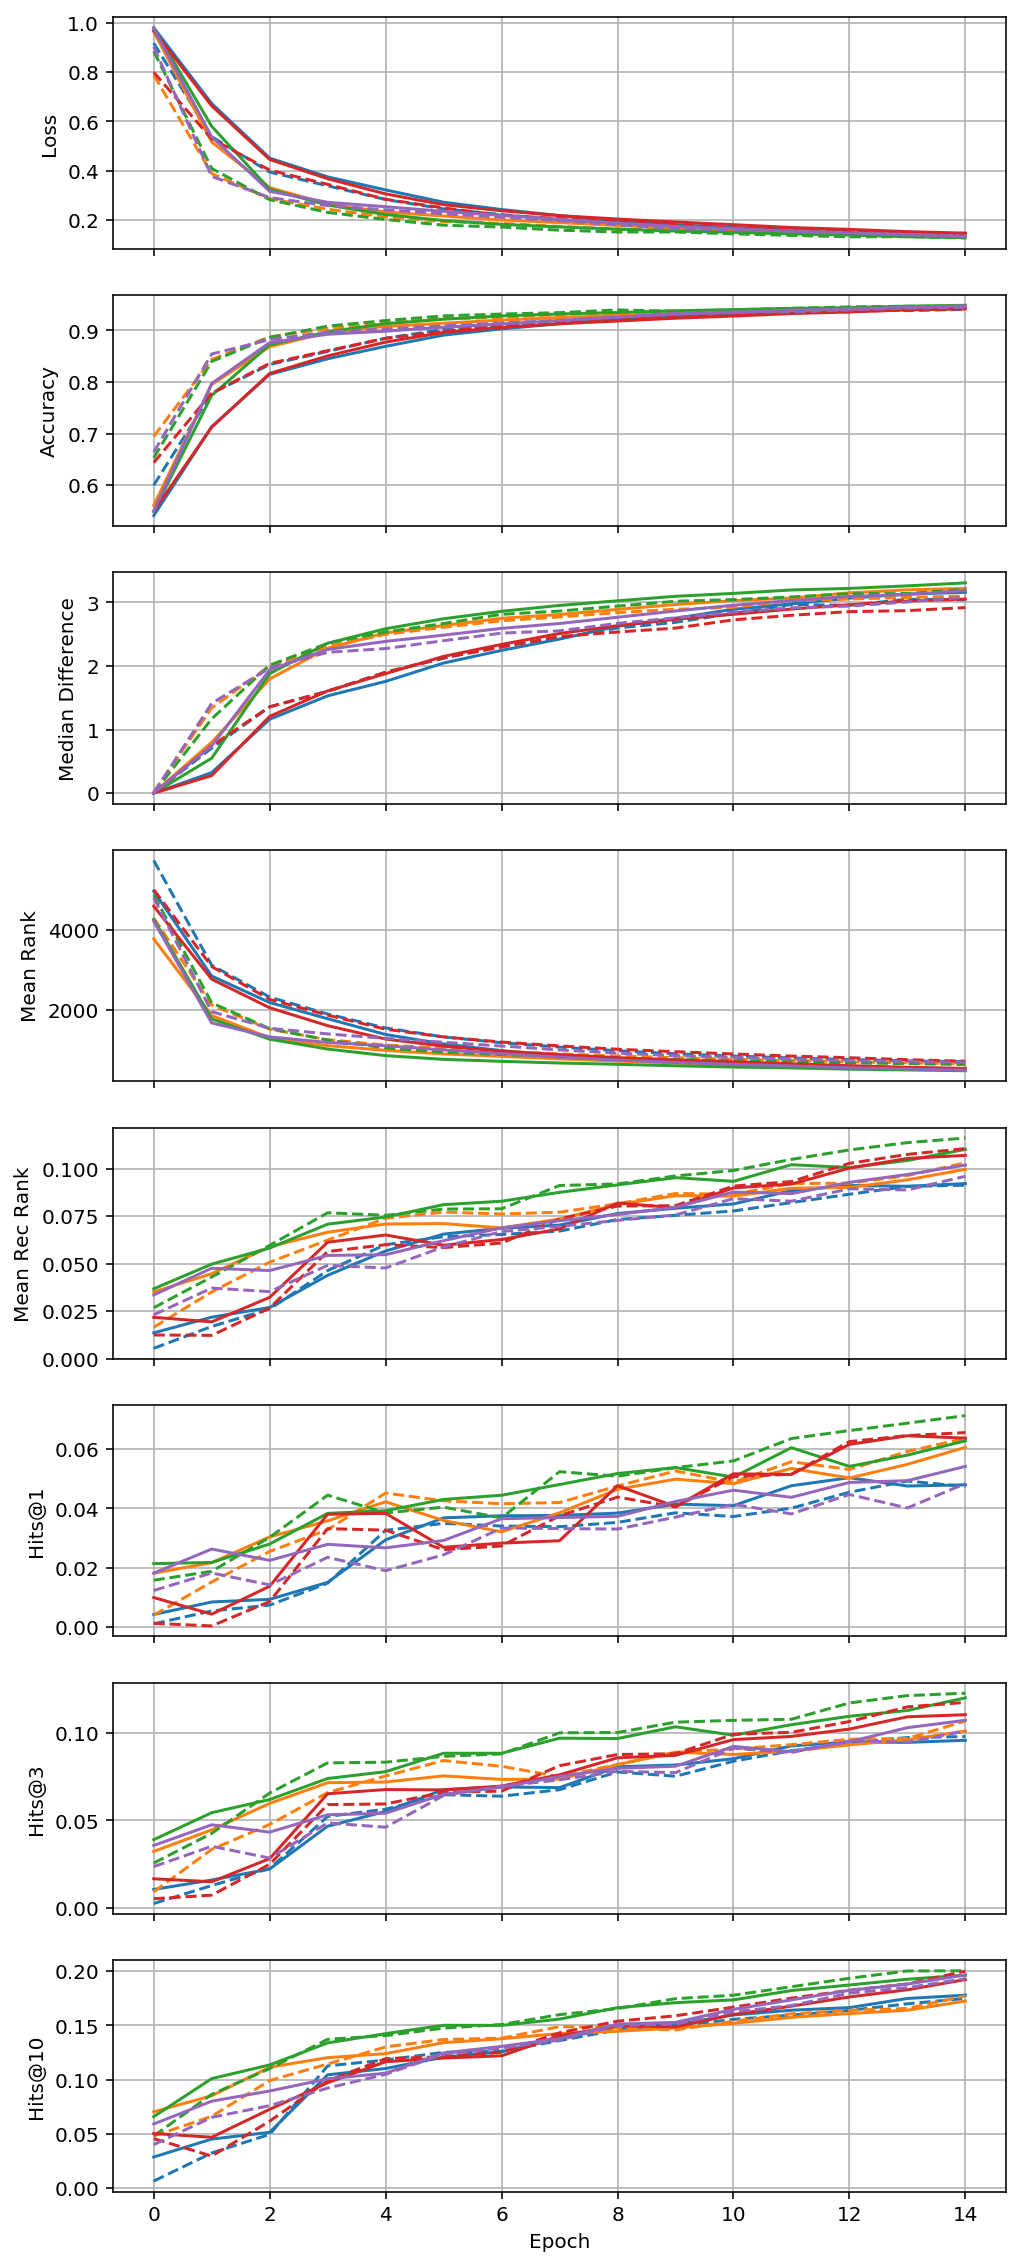

In [35]:
to_plot = ['loss', 'acc', 'median_diff', 'mean_rank', 'mean_rec_rank', 'hits_1', 'hits_3', 'hits_10']
figsize = (8, 20)

# TODO: Make fig legend for compare histories.
histories[0].plot(*to_plot, figsize=figsize, compare=histories[1:])#, xlim=(0, 10))

In [35]:
np.mean([max(h['val_mean_rec_rank']) for h in histories]), np.std([max(h['val_mean_rec_rank']) for h in histories]) / np.sqrt(len(histories))

(0.32256140108953557, 0.02670228591401082)

In [22]:
for i, h in enumerate(histories):
    h.save('logs/13-{}_filtered-ranking_same-parameters-with-different-seeds.tsv'.format(i))

In [20]:
!ls logs

10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv
11_dist-mult.tsv
12_rgcn_new-one-hot-embedding_raw-ranking.tsv
13-0_filtered-ranking_same-parameters-with-different-seeds.tsv
13-1_filtered-ranking_same-parameters-with-different-seeds.tsv
13-2_filtered-ranking_same-parameters-with-different-seeds.tsv
13-3_filtered-ranking_same-parameters-with-different-seeds.tsv
13-4_filtered-ranking_same-parameters-with-different-seeds.tsv
13-5_filtered-ranking_same-parameters-with-different-seeds.tsv
13-6_filtered-ranking_same-parameters-with-different-seeds.tsv
14-0_only-weight-initialization-seeded.tsv
14-1_only-weight-initialization-seeded.tsv
14-2_only-weight-initialization-seeded.tsv
14-3_only-weight-initialization-seeded.tsv
15-0_only-training-loop-seeded.tsv
15-1_only-training-loop-seeded.tsv
15-2_only-training-loop-seeded.tsv
15-3_only-training-loop-seeded.tsv
16-0_DistMult-unseeded.tsv
16-1_DistMult-unseeded.tsv
16-2_DistMult-unseeded.tsv
16-3_DistMult-unseeded.tsv
1_lin

# Bla

In [59]:
in_features = 10
out_features = 10
num_basis_weights = 3
num_relations = 3


basis_weights = nn.Parameter(torch.FloatTensor(num_basis_weights, out_features, in_features))
nn.init.xavier_uniform(basis_weights)
coefficients = nn.Parameter(torch.FloatTensor(num_relations, num_basis_weights))
#plt.hist(basis_weights[0].data.numpy());

In [51]:
basis_weights[0]

Variable containing:
 0.1646 -0.0984 -0.0569  0.1652  0.1422  0.1595 -0.0828  0.1638  0.1481  0.0834
-0.1661  0.0165  0.1568 -0.0819  0.1247  0.1695  0.1652  0.0093 -0.1042  0.0248
-0.1014  0.1026  0.0925  0.1232 -0.1496  0.1536 -0.0617  0.0101  0.0910 -0.1760
 0.1906 -0.1139 -0.0742  0.0050  0.1435  0.0195  0.1304  0.1602  0.1219  0.1768
-0.1813  0.0711 -0.0683 -0.1036 -0.1863 -0.1472 -0.1521 -0.1813 -0.0709 -0.0294
-0.1292  0.0930 -0.1803  0.1879 -0.0655  0.0652  0.1414  0.0729  0.0185 -0.0614
-0.1969  0.0750 -0.1170  0.0305  0.0218 -0.1503  0.0760 -0.0079  0.1177  0.1551
 0.0511  0.1035 -0.1041 -0.0188 -0.1377 -0.1710  0.0913  0.0739 -0.0770 -0.0553
 0.1621  0.1728 -0.0647  0.1841  0.1956 -0.0995 -0.0330  0.0768 -0.0090  0.0617
 0.1524 -0.1949 -0.0072  0.1025  0.0288 -0.0194  0.0853 -0.0591  0.0818  0.1689
[torch.FloatTensor of size 10x10]

In [52]:
coefficients

Parameter containing:
 4.9537e-34  4.5853e-41  2.4076e+33  4.5852e-41  1.7181e+32
 4.5852e-41  2.6563e+06  4.5852e-41  1.5058e+01  4.5852e-41
 7.9639e-31  4.5852e-41  3.1581e+27  4.5852e-41 -1.5882e-23
[torch.FloatTensor of size 3x5]

In [53]:
coefficients[0] * basis_weights

RuntimeError: The size of tensor a (5) must match the size of tensor b (10) at non-singleton dimension 2

In [57]:
coefficients[0].view(-1, 1, 1).shape, basis_weights.shape

(torch.Size([5, 1, 1]), torch.Size([5, 10, 10]))

In [61]:
(coefficients[0].view(-1, 1, 1) * basis_weights).sum(0)

Variable containing:

Columns 0 to 5 
 1.3965e+32  1.8282e+32  1.4983e+32 -2.1621e+32 -2.4555e+32 -5.0305e+32
 1.7692e+32  2.2083e+32 -4.6908e+32  3.8917e+32  4.5481e+32  2.7391e+32
 3.8892e+32 -2.5572e+32 -2.5895e+31  4.0720e+32 -1.3414e+32 -4.4901e+32
 3.5074e+32  4.8094e+31  3.4444e+32 -2.6301e+32 -3.3632e+31  2.9033e+32
 4.0926e+32  4.1274e+32 -4.9881e+31 -9.3499e+31  1.3801e+32 -2.7068e+32
-4.5370e+32  8.0056e+31  2.6328e+32 -1.6737e+32 -4.4015e+31  4.3087e+32
 4.4248e+32  3.3956e+32 -4.6301e+32 -4.3405e+32 -4.2724e+32  8.0870e+31
 1.9075e+32  2.0280e+32 -3.7964e+31 -1.1835e+32  1.8363e+32 -4.7773e+32
-1.1014e+32  8.8651e+31 -3.9782e+32  2.2477e+32 -2.6599e+31  4.5225e+32
-3.8174e+32 -9.5169e+31  3.9044e+32  3.3657e+31 -5.0020e+32 -2.3986e+32

Columns 6 to 9 
 7.8549e+30 -2.2947e+32 -2.4410e+32 -2.6862e+32
 5.1426e+32 -1.5311e+32  1.0454e+32  2.7752e+32
-3.3294e+32  4.1468e+32  2.0030e+31  4.7463e+31
 1.7601e+32 -3.8394e+32 -8.9438e+31  8.1630e+31
 3.3080e+32 -2.5735e+32  4.2263e+